In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import torch
import torch.nn as nn


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ag-news/ag_news_test.csv
/kaggle/input/ag-news/ag_news_train.csv


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

# 1) Load the data

In [3]:
train_df = pd.read_csv('/kaggle/input/ag-news/ag_news_train.csv')
test_df = pd.read_csv('/kaggle/input/ag-news/ag_news_test.csv')

print(train_df.head())
print('\n\n')
print(test_df.head())

   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  



   Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Private Team Sets Launc...   
2            4      Ky. Company Wins Grant to

# 2) Exploratory Data Analysis

In [4]:
# Shows amount of rows and columns
train_df.shape, test_df.shape

((120000, 3), (7600, 3))

In [5]:
#  How many classes
train_df['Class Index'].value_counts()

Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

In [6]:
# Both seem balanced which is good. No need for handling imbalanced data.
test_df['Class Index'].value_counts()

Class Index
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64

<Axes: >

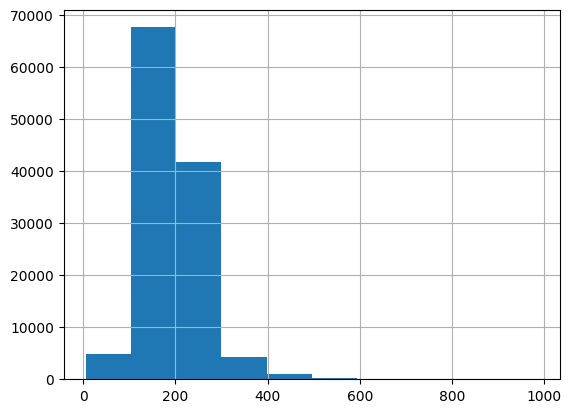

In [7]:
''' For fun, let's see the lengths of all the sentences. Seems like a majority in the 300 and on range, don't
    have many members. This makes me think that padding may be unnecessary because if padding were to occur then
    that's a lot of extra 0s to add (depending on the pad size) and therefore a lot of useless information for
    the model to expect. '''
train_df['Description'].str.len().hist()

# 3) Preprocessing

In [8]:
import torchtext
from torchtext.data.utils import get_tokenizer

''' First get tokenizer ready for other function soon. Tokenizers are used in nlp to turn strings/sentences
    into tokens. Ex: "The cat is sleeping" will become ['The', 'cat', 'is', 'sleeping'].

    tk = tokenizer '''

tk = get_tokenizer('basic_english')

In [9]:
# Example sentence for display
ex_sent = "This is a cool sentence."

tk(ex_sent)

['this', 'is', 'a', 'cool', 'sentence', '.']

In [10]:
''' Example from train_df.

    A tokenizing function with yield in it is necessary because the "yield" keyword will work with iteration. And
    that's what the build_vocab_from_iterator function will do. A vocab is a set of unique words in the dataset, so
    that'll be necessary to create. So yield function -> build_vocab_from_iterator -> Vocab.

    The yield keyword will make sure that the caller that's handling the function in a loop DOESN'T lose it's place so
    it can continue from where it left off. Ex: An array has 3 values [5,10,15], when the loop first runs, the yield
    function returns 5, then next it'll return 10.

    The example below explains in more detail. '''

# Just get a couple description sentences for displaying.
test_sentences = train_df['Description'].values.tolist()[:2]


def test_tokenized_sentence():
    for x in test_sentences:
        yield tk(x)


''' Enumerate just to show numerical order with the "i+1" part. Since the function is looped over, the yield statement
    kicks in every iteration and keeps it's place to continue '''
for i, x in enumerate(test_tokenized_sentence()):
    print(f'---Test sentence #{i+1}---\nOriginal sentence:\n{test_sentences[i]}\nTokenized sentence:\n{x}\n\n')

---Test sentence #1---
Original sentence:
Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Tokenized sentence:
['reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's', 'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.']


---Test sentence #2---
Original sentence:
Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Tokenized sentence:
['reuters', '-', 'private', 'investment', 'firm', 'carlyle', 'group', ',', '\\which', 'has', 'a', 'reputation', 'for', 'making', 'well-timed', 'and', 'occasionally\\controversial', 'plays', 'in', 'the', 'defense', 'industry', ',', 'has', 'quietly', 'placed\\its', 'bets', 'on', 'another', 'part', 'of', 'the', 'market', '.']




In [11]:
''' Steps for preprocessing :

    1) Lower text - "What" and "what" will be looked at as 2 different entities if not lowered.

    2) Remove non number/alpha chars - No need for !, #, etc.

    3) Tokenization - Explained above

    4) .join - ' '.join(["Some", "string", "here"]) will produce "'Some string here'" so join puts
        it back together.

    sent = sentence '''

def preprocessing(sent, print_steps=False):
    if print_steps is True:
        print(f'1) --- Current text:\n{sent}')
    sent = sent.lower()
    if print_steps is True:
        print(f'2) --- Post lower:\n{sent}')


    ''' Explanation of regex.
        \s - Finds single whitespace char
        \w - Matches char in str

        Observations:
            1) Doing " r'^\w " - Goes through the entire str, remember the rule google said:
                "The search proceeds through the string from start to end"

            2) re.sub(r'\w', '', test_sent) - Matches every char, so [a-zA-Z0-9_]. Replaces
                with nothing. Hence "'$  @ !!!'" returned.
            3) re.sub(r'\s', '', test_sent) - Matches every white space. And replace it with
                nothing, hence "'Th$sis@32434test!!!'"
            4) re.sub(r'[\w\s]', '', test_sent) - w gets rid of all chars its supposed to like
                [a-zA-Z0-9_] and also \s gets rid of all white spaces. Hence "'$@!!!'"

            Why does ^ reverse it and remove special chars?
            Answer:
            "An up-hat (^) at the start of a square-bracket set inverts it, so [^ab] means
            any char except 'a' or 'b'." from google source:
            https://developers.google.com/edu/python/regular-expressions
            So both \w\s say together "Let's replace all chars [a-zA-Z0-9_] and white spaces
            with nothing". BUT, the ^ stops and says do the opposite of that and instead
            keeps all the matching chars and white spaces. It's genius. '''
    sent = re.sub(r'[^\w\s]', '', sent)
    if print_steps is True:
        print(f'3) --- Post regex sub (remove non alpha numerical chars):\n{sent}')

    sent = tk(sent)
    if print_steps is True:
        print(f'4) --- Post tokenization:\n{sent}')

    sent = ' '.join(sent)
    if print_steps is True:
        print(f'5) --- Post join:\n{sent}')

    return sent


# Example
preprocessing("Shocking!!! How could group 46 do that?!", True)

1) --- Current text:
Shocking!!! How could group 46 do that?!
2) --- Post lower:
shocking!!! how could group 46 do that?!
3) --- Post regex sub (remove non alpha numerical chars):
shocking how could group 46 do that
4) --- Post tokenization:
['shocking', 'how', 'could', 'group', '46', 'do', 'that']
5) --- Post join:
shocking how could group 46 do that


'shocking how could group 46 do that'

In [12]:
# Examples from dataframe. Zip can take a range and loop only that many times.
for i, x in zip(range(2), train_df['Description']):
    preprocessing(x, True)
    print('\n\n\n')

1) --- Current text:
Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
2) --- Post lower:
reuters - short-sellers, wall street's dwindling\band of ultra-cynics, are seeing green again.
3) --- Post regex sub (remove non alpha numerical chars):
reuters  shortsellers wall streets dwindlingband of ultracynics are seeing green again
4) --- Post tokenization:
['reuters', 'shortsellers', 'wall', 'streets', 'dwindlingband', 'of', 'ultracynics', 'are', 'seeing', 'green', 'again']
5) --- Post join:
reuters shortsellers wall streets dwindlingband of ultracynics are seeing green again




1) --- Current text:
Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
2) --- Post lower:
reuters - private investment firm carlyle group,\which has a reputation for making well-timed and occasionally\contr

In [13]:
# Apply function to both dataframes
train_df['preprocessed_sentences'] = train_df['Description'].apply(preprocessing)
test_df['preprocessed_sentences'] = test_df['Description'].apply(preprocessing)

In [14]:
train_df.head()

,Class Index,Title,Description,preprocessed_sentences
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",reuters shortsellers wall streets dwindlingban...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,reuters private investment firm carlyle groupw...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,reuters soaring crude prices plus worriesabout...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,reuters authorities have halted oil exportflow...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",afp tearaway world oil prices toppling records...


In [15]:
test_df.head()

,Class Index,Title,Description,preprocessed_sentences
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,unions representing workers at turner newall s...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",spacecom toronto canada a secondteam of rocket...
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,ap a company founded by a chemistry researcher...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,ap its barely dawn when mike fitzpatrick start...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,ap southern californias smogfighting agency we...


# 4) Splitting

In [16]:
from sklearn.model_selection import train_test_split

''' Potential reason why validation accuracy was decreasing:

    1) train_test_split - doesn't shuffle properly. Earlier I took a screenshot on my phone of this
        cell to see if it would produce the same output and it did. It's because random_state was
        involved. So the same output everytime. I overlooked previous verions of the project and this
        is correct. Versions 13-15, all output the same. So not that much random shuffling going on.


'''

# Only one file which is ag_news_train.csv. need validation data.
x_train, x_val, y_train, y_val = train_test_split(train_df['preprocessed_sentences'],
                                                  train_df['Class Index'],
                                                  test_size=0.2)
# Display a few
num_to_display = 3
print(f'x_train:\n{x_train[:num_to_display]}\n\ny_train:\n{y_train[:num_to_display]}')

x_train:
76995    mandrakesoft has introduced mandrakelinux 101 ...
13921    canadian press halifax cp two turns of a screw...
32166    ap wily mo pena hit two home runs to offset a ...
Name: preprocessed_sentences, dtype: object

y_train:
76995    4
13921    1
32166    2
Name: Class Index, dtype: int64


In [17]:
x_val.head()

100780    ap auburns defense at least made a decent case...
43972     after a modest playing career in serie a and b...
116798    iran told nuclear partner russia on wednesday ...
103161    the first nine holes of the merrill lynch skin...
116307    new orleans sports network dustin almond passe...
Name: preprocessed_sentences, dtype: object

In [18]:
y_val.head()

100780    2
43972     2
116798    1
103161    2
116307    2
Name: Class Index, dtype: int64

In [19]:
# Correct the indices
x_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

print(f'x_train:\n{x_train.head()}\n\ny_train:\n{y_train.head()}\n\n')
print(f'x_val:\n{x_val.head()}\n\ny_val:\n{y_val.head()}\n\n')

x_train:
0    mandrakesoft has introduced mandrakelinux 101 ...
1    canadian press halifax cp two turns of a screw...
2    ap wily mo pena hit two home runs to offset a ...
3    marvin burroughs and terry butler each scored ...
4    brasilia brazil reuters the united states and ...
Name: preprocessed_sentences, dtype: object

y_train:
0    4
1    1
2    2
3    2
4    1
Name: Class Index, dtype: int64


x_val:
0    ap auburns defense at least made a decent case...
1    after a modest playing career in serie a and b...
2    iran told nuclear partner russia on wednesday ...
3    the first nine holes of the merrill lynch skin...
4    new orleans sports network dustin almond passe...
Name: preprocessed_sentences, dtype: object

y_val:
0    2
1    2
2    1
3    2
4    2
Name: Class Index, dtype: int64




# 5) Tokenize training text

In [20]:
x_train_tokens = [tk(sent) for sent in x_train]
x_val_tokens = [tk(sent) for sent in x_val]


# Display a few
print(f'{num_to_display} x_train sentences:\n{x_train[:num_to_display]}\n')
print(f'THEN {num_to_display} x_train_tokens sentences:\n{x_train_tokens[:num_to_display]}\n\n\n')

print(f'{num_to_display} x_val sentences:\n{x_val[:num_to_display]}\n')
print(f'THEN {num_to_display} x_val_tokens sentences:\n{x_val_tokens[:num_to_display]}')

3 x_train sentences:
0    mandrakesoft has introduced mandrakelinux 101 ...
1    canadian press halifax cp two turns of a screw...
2    ap wily mo pena hit two home runs to offset a ...
Name: preprocessed_sentences, dtype: object

THEN 3 x_train_tokens sentences:
[['mandrakesoft', 'has', 'introduced', 'mandrakelinux', '101', 'official', 'with', 'the', 'promise', 'that', 'its', 'latest', 'distribution', 'provides', 'extended', 'support', 'for', 'mobile', 'devices', 'better', 'hardware', 'compatibility', 'and', 'major', 'application', 'upgrades'], ['canadian', 'press', 'halifax', 'cp', 'two', 'turns', 'of', 'a', 'screw', 'caused', 'the', 'spectacular', 'crash', 'of', 'a', 'sea', 'king', 'helicopter', 'onto', 'the', 'deck', 'of', 'a', 'canadian', 'destroyer', 'at', 'sea', 'last', 'year'], ['ap', 'wily', 'mo', 'pena', 'hit', 'two', 'home', 'runs', 'to', 'offset', 'a', 'pair', 'by', 'moises', 'alou', 'and', 'lead', 'the', 'cincinnati', 'reds', 'over', 'the', 'chicago', 'cubs', '65', 'saturd

# 6) Building vocab

In [21]:
from torchtext.vocab import build_vocab_from_iterator

def get_tokenized_sentences(sentences):
    for sent in sentences:
        yield tk(sent)

# Get all preprocessed sentences into a list and create list for tokenized sentences
all_sentences = train_df['preprocessed_sentences'].values.tolist()


''' To build vocab in pytorch, use build_vocab_from_iterator (bvfi). It takes a function as an arg, and
    that function takes an interable. Function must use yield and yield will pause every iteration to
    continue from where it left off.

    "unk" key is for when the vocab gets unknown words. When the vocab is built, it will KNOW, n amount
    of words. However if a new word comes in and it's not familar with it, it'll be classified as
    unk for unknown. '''

vocab = build_vocab_from_iterator(get_tokenized_sentences(all_sentences), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [22]:
# Get entire dictionary which contains key,value pairs of string/ints
d = vocab.get_stoi()

# Display a few. Each string with an assigned number.
for index, key_value in zip(range(5), d.items()):
    print(f'Key: {key_value[0]}. Value: {key_value[1]}')

Key: zzz. Value: 93146
Key: zz. Value: 93145
Key: zy2. Value: 93142
Key: zwiki. Value: 93141
Key: zviadauri. Value: 93140


In [23]:
# Can now convert whole sentences into nums. Example below.
def convert_sent_to_nums(sent, print_steps=False):
    if print_steps is True:
        print(f'Sentence (as it is):\n{sent}\n')
    return vocab(tk(sent))

c = convert_sent_to_nums(train_df['preprocessed_sentences'][0], True)
print(f'Converted sentence:\n{c}')

Sentence (as it is):
reuters shortsellers wall streets dwindlingband of ultracynics are seeing green again

Converted sentence:
[27, 46232, 389, 1702, 62474, 4, 47639, 32, 3564, 789, 394]


In [24]:
# Loop up the above values just to double check. itos returns dictionary where keys are numbers, that's why this works
[vocab.get_itos()[num] for num in c]

['reuters',
 'shortsellers',
 'wall',
 'streets',
 'dwindlingband',
 'of',
 'ultracynics',
 'are',
 'seeing',
 'green',
 'again']

In [25]:
# Now convert all preprocessed strings and display a few
x_train_sequences = [vocab(tk(text)) for text in x_train]
x_val_sequences = [vocab(tk(text)) for text in x_val]

print(f'x_train_sequences:\n{x_train_sequences[:num_to_display]}\n')
print(f'x_val_sequences:\n{x_val_sequences[:num_to_display]}\n')

x_train_sequences:
[[15598, 19, 1272, 34089, 7223, 260, 11, 1, 3042, 9, 13, 263, 2728, 2982, 1389, 407, 8, 242, 715, 597, 1910, 8672, 6, 159, 1090, 5997], [458, 365, 5504, 772, 37, 3539, 4, 2, 19982, 1235, 1, 4329, 1891, 4, 2, 1712, 1502, 2622, 2250, 1, 11822, 4, 2, 458, 61493, 14, 1712, 53, 62], [34, 30593, 4930, 29397, 238, 37, 148, 948, 3, 2417, 2, 1832, 17, 14283, 11757, 6, 178, 1, 1879, 3363, 33, 1, 361, 1830, 2081, 88, 90]]

x_val_sequences:
[[34, 20502, 494, 14, 161, 156, 2, 9217, 509, 8, 85, 258], [28, 2, 3748, 974, 799, 5, 4645, 2, 6, 3734, 11, 85552, 64818, 76179, 6, 17691, 4217, 15637, 1361, 46, 23, 38, 3126, 539, 5, 604, 7416, 11, 87656, 5, 4645, 24569, 1214, 10, 415, 606], [575, 441, 292, 2130, 462, 7, 42, 18, 72, 29, 3, 540, 81064, 82, 3, 1538, 292, 2031, 11, 1433, 3, 1377, 2, 2183, 379, 4, 575, 10, 1688, 117, 5, 510, 4, 695, 682, 22, 444]]



In [26]:
# Show example of original text in one of the x_train_sequences by converting
def convert_num_to_sentence(nums, print_steps=False):
    if print_steps is True:
        print(f'NUMERICAL sentence (as it is):\n{nums}\n')

    # get_itos gets a dictionary of int and str pairs. Pass num to get str equal
    s = [vocab.get_itos()[num] for num in nums]

    # Then join for original string
    return ' '.join(s)

convert_num_to_sentence(x_train_sequences[0], True)

NUMERICAL sentence (as it is):
[15598, 19, 1272, 34089, 7223, 260, 11, 1, 3042, 9, 13, 263, 2728, 2982, 1389, 407, 8, 242, 715, 597, 1910, 8672, 6, 159, 1090, 5997]



'mandrakesoft has introduced mandrakelinux 101 official with the promise that its latest distribution provides extended support for mobile devices better hardware compatibility and major application upgrades'

# 7) Padding

In [27]:
# Padding takes num sentences of different lengths into the same length.

# test pad value
max_len = 5

# Get an example num sentence
test_num_sent = x_train_sequences[0]
print(f'Current numerical sentence:\n{test_num_sent}\nLength: {len(test_num_sent)}\n\n')

# Convert to tensor because .pad func in torch requires tensors
test_num_sent = torch.tensor(test_num_sent)
print(f'Current numerical sentence as tensor:\n{test_num_sent}\n\n')

''' "(0, max_len - len(test_num_sent))" - Does the math. 2 classes

    1) Length of sentence shorter than padded value - Ex: If sent is 20 nums long and
        padding value/max_len is 50, 30 0s is added. That's where the "0" value comes into
        play in the arguments. "max_len - len(test_num_sent)" is 50 - 20 = 30, so 30 0s added.

    2) Length of sentence LONGER than padded value - Ex: If sent is 17 nums long and padding value/
        max_len is 5. The opposite happens. The sentence is chopped off or truncated to get to
        max len of 5. "max_len - len(test_num_sent)" is 5 - 17 = -12 '''

test_num_sent = torch.nn.functional.pad(test_num_sent, (0, max_len - len(test_num_sent)), mode='constant', value=0)
print(f'Padded numerical sentence as tensor:\n{test_num_sent}\nNew length: {len(test_num_sent)}')

Current numerical sentence:
[15598, 19, 1272, 34089, 7223, 260, 11, 1, 3042, 9, 13, 263, 2728, 2982, 1389, 407, 8, 242, 715, 597, 1910, 8672, 6, 159, 1090, 5997]
Length: 26


Current numerical sentence as tensor:
tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997])


Padded numerical sentence as tensor:
tensor([15598,    19,  1272, 34089,  7223])
New length: 5


In [28]:
# Out of curiosity what is the max length of numerical sentences?
max_num = max(len(x) for x in x_train_sequences)

max_num

173

In [29]:
# Get length of all num lists for graphing soon
x_train_lengths = [len(list_of_nums) for list_of_nums in x_train_sequences]

In [30]:
series_lengths = pd.Series(data=x_train_lengths)

series_lengths

0        26
1        29
2        27
3        25
4        31
         ..
95995    21
95996    26
95997    34
95998    28
95999    43
Length: 96000, dtype: int64

<Axes: >

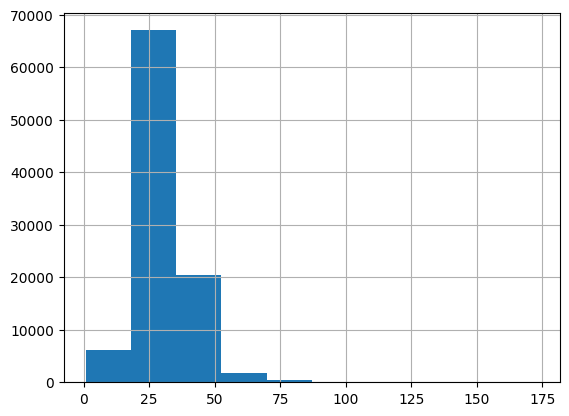

In [31]:
''' This shows padding to the max length probably isn't best. A few cells ago, in "Exploratory Data Analysis", the
    dataframes description lengths were shown in a graph. Even with that one, based on raw sentence lengths, a vast
    majority were clustered together. Below shows the x_train_sequences lengths, and still a majority clustered
    together. So padding to max len of 1033 will NOT be done, a smaller value will be chosen. '''

series_lengths.hist()

In [32]:
# Use same num sentence and pad to greater length as an example
test_num_sent = torch.tensor(x_train_sequences[0])

''' "(len(test_num_sent) * 2) - len(test_num_sent)" Guarantees we'll have to pad and add 0s. Why? If length is 25, then
    25 * 2 = 50. Minus the original length (using len(test_num_sent)) which is 25. This will require a new tensor length
    DOUBLE that what it is, of course padded with 0s. '''

a = torch.nn.functional.pad(test_num_sent,
                            (0, (len(test_num_sent) * 2) - len(test_num_sent)),
                            mode='constant',
                            value=0)

print(f'Test_num_sent:\n{test_num_sent}\nLength: {len(test_num_sent)}\nNew padded sent:\n{a}\nLength: {len(a)}')

Test_num_sent:
tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997])
Length: 26
New padded sent:
tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
Length: 52


In [33]:
# The series_length series object has all the lengths in the x_train_sequences. Need a good way to get a max padding.
s = series_lengths.to_numpy()
print(f'Numpy conversion of length numbers:\n{s}\n')

# Convert to tensor for sort.
s = torch.tensor(s)
print(f'Tensor of numbers:\n{s}\n')

''' Sort with pytorch and get numpy arr again. Reason I did this was to VISUALLY see the numbers to compare with the
    previously displayed graph. There's a tiny bar on the 75 mark but a portion goes to the right so I assume there's a
    somewhat significant amount of numbers after 75.

    Below shows me that after 90, the consistency of each number after in terms of how many there are, drops off.
    I'll chose 90 for padding.  '''
s = s.sort().values.tolist()
print(set(s))

Numpy conversion of length numbers:
[26 29 27 ... 34 28 43]

Tensor of numbers:
tensor([26, 29, 27,  ..., 34, 28, 43])

{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 126, 127, 128, 130, 131, 133, 135, 137, 138, 140, 141, 146, 151, 160, 168, 173}


In [34]:
def pad_num_sentences(num_sent, max_pad_length):
    # return torch.nn.functional.pad(torch.tensor(num_sent), (0, max_pad_length - len(num_sent)), mode='constant', value=0)

    # Type specification should solve error.
    return torch.nn.functional.pad(torch.tensor(num_sent, dtype=torch.int64), (0, max_pad_length - len(num_sent)), mode='constant', value=0)

# A few cells ago, decision was made not to use max length, but a value closer to the range of most num sentences.
max_padding_len = 90

# cs = current sequence
x_train_padded = [pad_num_sentences(cs, max_padding_len) for cs in x_train_sequences]
x_val_padded = [pad_num_sentences(cs, max_padding_len) for cs in x_val_sequences]

# Display
print(f'x_train_padded:\n{x_train_padded[:num_to_display]}\n\n')
print(f'x_val_padded:\n{x_val_padded[:num_to_display]}\n\n')

x_train_padded:
[tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor([  458,   365,  5504,   772,    37,  3539,     4,     2, 19982,  1235,
            1,  4329,  1891,     4,     2,  1712,  1502,  2622,  2250,     1,
        11822,     4,     2,   458, 61493,    14,  1712,    53,    62,     0,
            0,     0,     0,     0,     0,   

In [35]:
''' Checking types again. Old error was "Expected tensor for argument #1 'indices' to have one of the following scalar types:
    Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)". In previous cell, the old
    pad line is commented out because that was used before, no type specification so I assume the function TRIED to assume
    the type. Didn't work out.

    Loop shouldn't print anything if all is well. '''

for i, cur_padded_tensor in enumerate(x_train_padded):
    if cur_padded_tensor.dtype != torch.int64:
        print(f'Index {i} has non int64 type!')

In [36]:
# Also print the type out to make absolutely sure
x_train_padded[0].dtype

torch.int64

# 8) Changing labels

In [37]:
y_train_np = y_train.values
y_val_np = y_val.values

y_train_np, y_val_np

(array([4, 1, 2, ..., 1, 1, 2]), array([2, 2, 1, ..., 1, 1, 4]))

In [38]:
# Wondering what the labels were in both
set(y_train_np), set(y_val_np)

({1, 2, 3, 4}, {1, 2, 3, 4})

In [39]:
max_of_y = max(set(y_train_np))

max_of_y

4

In [40]:
''' If labels 1,2,3,4, there's a way to index at 0. Just get the biggest value and set that to 0.
    Ex: labels are 1,2,3,4. Get 4, set every value of 4 in a dataframe column/series to 0. '''
y_train_np[y_train_np == max_of_y] = 0
y_val_np[y_val_np == max_of_y] = 0

set(y_train_np), set(y_val_np)

({0, 1, 2, 3}, {0, 1, 2, 3})

In [41]:
y_train_np, y_val_np

(array([0, 1, 2, ..., 1, 1, 2]), array([2, 2, 1, ..., 1, 1, 0]))

# 9) Dataset & DataLoaders

In [42]:
from torch.utils.data import Dataset

''' Datasets make managing data easier in pytorch, especially for image projects. Data LOADERS help get certain amounts of data 
    in a batch_size. Even better, the collate_fn argument of the DataLoader function is the all star of the class and you'll see
    why in the "# 15) Building data for Lstm & Embedding bag layer" section. Quick explanation why collate_fn is so good is because
    if it's provided a function, then the data that was given TO DataLoader (say x_train for example) will go to that function
    and can get preprocessed in one spot. '''

class TextDataset(Dataset):
    def __init__(self, padded_sentences, labels):
        self.padded_sentences = padded_sentences
        self.labels = labels

    def __len__(self):
        return len(self.padded_sentences)

    def __getitem__(self, index):
        return self.padded_sentences[index], self.labels[index]

train_data = TextDataset(x_train_padded, y_train_np)
val_data = TextDataset(x_val_padded, y_val_np)

# Print out some data just for display.
for i in train_data:
    print(i)
    print(i[0].dtype)
    break

(tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 0)
torch.int64


In [43]:
train_data[0]

(tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
            13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
          1910,  8672,     6,   159,  1090,  5997,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 0)

In [44]:
# Test sentence for conversion back to words.
test_inp = train_data[0]
print(f'Padded numerical test input:\n{test_inp}')

''' Must index because train_data is dataset and was used above to get numerical sentence. Dataset returns tuples of
    numerical sentences and labels. '''
indices_of_vocab_nums = torch.nonzero(test_inp[0])

# No real reason to reshape, other than I'd rather view the numbers horizontally.
indices_of_vocab_nums.reshape(1, -1)

Padded numerical test input:
(tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 0)


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25]])

In [45]:
''' Only need last value. Squeeze drops the dimensions from 2d to 1d. Then negative index to
    get last one. .item() just gets the number out. '''
index = indices_of_vocab_nums.squeeze()[-1].item()
print(f'Index of last vocab word: {index}\n\n')

# Get numerical sentence. test_inp is tuple, as seen below.
num_sent = test_inp[0][:index+1]
print(f'Numerical sentence:\n{num_sent}\n\n')

# Use vocab object to convert to original
text_sent = ' '.join([vocab.get_itos()[num] for num in num_sent])
print(f'Real text sentence:\n{text_sent}\n\n')

Index of last vocab word: 25


Numerical sentence:
tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997])


Real text sentence:
mandrakesoft has introduced mandrakelinux 101 official with the promise that its latest distribution provides extended support for mobile devices better hardware compatibility and major application upgrades




In [46]:
''' Could of also used x_train_sequences since it contains the original nums, TO CONVERT TO SHOW,
    as shown below. But above was a slightly different challenge regarding getting rid of padding. '''
z = ' '.join([vocab.get_itos()[num] for num in x_train_sequences[0]])
print(f'Same sentence converted (but from x_train_sequences):\n{z}')

Same sentence converted (but from x_train_sequences):
mandrakesoft has introduced mandrakelinux 101 official with the promise that its latest distribution provides extended support for mobile devices better hardware compatibility and major application upgrades


In [47]:
from torch.utils.data import DataLoader

batch_size = 64

# DataLoaders handle batch sizes. When collate_fn arg is supplied, can handle preprocessing as well.
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [48]:
for x,y in train_loader:
    print(x)
    print(len(x))
    break

len(train_loader)

tensor([[    1,  2174,   217,  ...,     0,     0,     0],
        [22451,    11,  2475,  ...,     0,     0,     0],
        [ 3001,  4643,     6,  ...,     0,     0,     0],
        ...,
        [ 3623,    14,     2,  ...,     0,     0,     0],
        [    5,     2,  2738,  ...,     0,     0,     0],
        [   34,  8335,  1212,  ...,     0,     0,     0]])
64


1500

# 10) Understanding Embedding & LSTM

In [49]:
''' Embedding layer maps each word in the vocab with a tensor of size n to represent it in the neural network.
    Ex: Embedding dim is 125 (like below)? Each word in vocab gets tensor of size 125 to represent it.
    Also 20 represents the vocabulary size. Meaning NO numerical value in the given tensor is allowed to exceed
    20 or "IndexError: index out of range in self" error is thrown. '''

nn.Embedding(20, 125)

Embedding(20, 125)

In [50]:
''' Demonstrating the "IndexError: index out of range in self" error. As stated before, embedding layer must take in numbers
    that do not exceed the input size. Likely input size will match vocab size. Ex: If vocab is 5 words like dictionary
    below, it won't be able to process a numerical value that's out of range of that dictionary. '''

# t = testing
t_dict = {
    'hello':0,
    'world':1,
    'nice':2,
    'seeing':3,
    'you':4
}

t_vocab_size = len(t_dict)
t_embedding_dim = 125

# Input to embedding layer matches size of dictionary, which is 5 as of now. No value in tensor can match/exceed this value.
el = nn.Embedding(t_vocab_size, t_embedding_dim)
print(f'Embedding layer dimensions in form (input, embedding_dim/output): {el}\n')

# A few tensors to try. Feel free to pass any one of them to the layer as done below.
t_one = torch.tensor([4,3,1]) # Works
t_two = torch.tensor([7,0]) # Does not work. 7 >= 5
t_three = torch.tensor([5,1,1,1]) # Does not work. 5 >= 5

t_four = torch.tensor([[1,2,4],
                       [0,3,2]]) # Works
t_five = torch.tensor([[3,4,1,10,2],
                       [1,2,9,3, 0]]) # Does not work. 10 & 9 >= 5

# Length is 3 because t_one has 3 values. An embedding vector of 125 (t_embedding_dim) is given for each one
output = el(t_one)
print(f'Output length: {len(output)}\n\nShape: {output.shape}\n\nOutput tensor:\n{output}')

Embedding layer dimensions in form (input, embedding_dim/output): Embedding(5, 125)

Output length: 3

Shape: torch.Size([3, 125])

Output tensor:
tensor([[-0.7364,  1.0081, -0.2853, -1.2978,  1.3933, -0.0074,  2.2088,  0.0057,
         -0.3879, -0.0064, -1.6855,  3.3009,  1.7030,  0.0620, -0.4034,  1.3300,
         -0.2211,  0.8079,  0.8934, -1.9823, -0.0489,  0.3957,  1.2497,  0.5609,
          0.4437,  1.1929,  0.4995, -0.8290,  1.3527,  0.8766, -0.0754, -1.6466,
         -0.5807, -1.0994,  0.7064,  1.0310,  1.0944, -0.7049, -0.2420,  0.0806,
          0.3705,  2.1074, -0.7814, -0.0078,  0.2357,  1.5296, -0.6091, -0.2778,
          0.3163, -3.0679, -0.3418, -1.9306,  0.3509,  0.1780,  1.2692, -2.9138,
         -0.5983,  0.3438,  0.5856,  1.0409,  0.7977, -0.7025,  0.1503, -0.0324,
          1.5010,  0.9429, -0.8761, -0.7157, -1.4247,  0.0898,  0.3732, -0.1142,
          0.0500,  0.9862,  0.4536,  1.2452, -0.6166,  0.1776,  0.9766, -0.2416,
          1.0110,  0.3958, -2.8329, -1.6413

In [51]:
t_hidden_dim = 225
t_layers = 1

''' Output of embedding is input to lstm. Same concept for all layers. Hence embedding_dim here as
    input. Although this isn't demanded by the code itself. Ex: If t_embedding_dim is 125, it's
    acceptable to give an input tensor like (1 (batch_size)), 1 (sequence_length), 207 (random number))
    to lstm_layer. No ERROR will come back, BUT some nan values will appear in the tensors which
    is not ideal.

    When lstm layers are called like "lstm_layer(input)" the return 2 values.

    1) output (cell state) - Same shape as the input. If input is 1,3,125, then so will this tensors
        shape.

    2) hidden state - The hidden state will return tensors of size (#, #, hidden_size). Last argument
        is for the variable above t_hidden_dim. So 2 tensors (#,#,225).

    Also regarding layers? They're the # of layers stacked. Ex: If given 2 and layers stacked, the output
      of 1 lstm is input to the next. Can potentially increase accuracy. '''

lstm_layer = nn.LSTM(input_size=t_embedding_dim,
                     hidden_size=t_hidden_dim,
                     num_layers=t_layers,
                     batch_first=True)

lstm_layer

LSTM(125, 225, batch_first=True)

In [52]:
# Displays things about input to lstm layer, and returning cell & hidden states.
def layer_results(inp, layer, return_output=False):
    print(f'Tensor input shape: {inp.shape}\nTensor:\n{inp}\n\n')

    output, hidden = layer(inp)
    print(f'Output shape: {output.shape}\nOutput tensor:\n{output}\n\n')
    print(f'Hidden state index 0 & index 1 shape (the same): {hidden[0].shape} - {hidden[1].shape}\n')
    print(f'Hidden state index 0 tensor:\n{hidden[0]}\n\nHidden state index 1 tensor:\n{hidden[1]}\n\n')

    if return_output is True:
        return output, hidden

In [53]:
# Keep random numbers somewhat constant.
torch.manual_seed(2)

''' Creating input data for layer in shape (batch_size, sequence_len, t_embedding_dim)
    1) batch_size - Like batches of data in data loaders, how large will the data be?

    2) seq_len - LSTM can take sequences of different lengths and output that at each time step. If seq_len was
        1, it gave 1 row in the input tensor. With 3? It shows 3 rows of output data. Ex: If input tensor is
        1,3,125 that's a 3d tensor with 3 tensors in it. Output variable (batch_size, sequence_length, hidden_dim).
        Hidden states unaffected with both shapes #,#,hidden_dim '''
batch_size = 1
seq_len = 1

input_tensor = torch.rand(batch_size, seq_len, t_embedding_dim)

''' Test it on lstm. Remember:

    lstm layers return cell state (sometimes called "out") & hidden state so the return value of
    hidden will be a tuple. output - Shape is (batch_size, seq_len, hidden_dim). hidden - BOTH
    shapes in tuple are same '''
output, hidden = lstm_layer(input_tensor)

# See the shapes that result from giving the input tensor to the lstm layer
layer_results(input_tensor, lstm_layer)

Tensor input shape: torch.Size([1, 1, 125])
Tensor:
tensor([[[0.6147, 0.3810, 0.6371, 0.4745, 0.7136, 0.6190, 0.4425, 0.0958,
          0.6142, 0.0573, 0.5657, 0.5332, 0.3901, 0.9088, 0.5334, 0.7073,
          0.7116, 0.2050, 0.3078, 0.9809, 0.0103, 0.4660, 0.4604, 0.8547,
          0.4525, 0.6317, 0.4760, 0.2200, 0.2166, 0.2571, 0.0458, 0.1755,
          0.6177, 0.8291, 0.5246, 0.2708, 0.7197, 0.3081, 0.3892, 0.2259,
          0.3430, 0.0367, 0.7133, 0.6944, 0.5993, 0.7455, 0.7119, 0.5221,
          0.5530, 0.5382, 0.7668, 0.8359, 0.8591, 0.7898, 0.3781, 0.4777,
          0.3984, 0.7909, 0.5555, 0.9628, 0.7536, 0.0727, 0.6463, 0.9804,
          0.9441, 0.4921, 0.6659, 0.0310, 0.3406, 0.7438, 0.0445, 0.9356,
          0.1712, 0.6581, 0.4811, 0.5881, 0.5484, 0.0326, 0.3926, 0.1839,
          0.9251, 0.4386, 0.0021, 0.6211, 0.7171, 0.2762, 0.4531, 0.7162,
          0.1889, 0.2357, 0.4518, 0.1489, 0.8073, 0.5409, 0.7992, 0.7677,
          0.1147, 0.1884, 0.1580, 0.3393, 0.3173, 0.4194, 0.

In [54]:
''' Input here is 1,4,125. 4 is sequence length. Below now displays input tensor being 3d but still has 4 rows.
    of data to handle. '''
x = torch.rand(batch_size, 4, t_embedding_dim)

layer_results(x, lstm_layer)

Tensor input shape: torch.Size([1, 4, 125])
Tensor:
tensor([[[0.1416, 0.3217, 0.8403, 0.0139, 0.0618, 0.1611, 0.6558, 0.2958,
          0.0541, 0.6938, 0.7529, 0.6873, 0.0716, 0.9869, 0.4623, 0.0241,
          0.4247, 0.8266, 0.7303, 0.4947, 0.8525, 0.0438, 0.8469, 0.9963,
          0.1960, 0.6072, 0.4194, 0.0779, 0.4956, 0.3324, 0.0729, 0.1357,
          0.5109, 0.9635, 0.6790, 0.1673, 0.8449, 0.5410, 0.0114, 0.5237,
          0.8210, 0.2060, 0.4770, 0.2509, 0.1057, 0.2159, 0.5502, 0.8232,
          0.4071, 0.0503, 0.4957, 0.0651, 0.5294, 0.8707, 0.7134, 0.1942,
          0.3897, 0.7002, 0.6356, 0.0303, 0.2085, 0.3232, 0.6837, 0.9468,
          0.7228, 0.6889, 0.0757, 0.8235, 0.6791, 0.3392, 0.2601, 0.6421,
          0.2290, 0.7030, 0.8824, 0.1701, 0.1881, 0.2923, 0.0719, 0.4427,
          0.8114, 0.6871, 0.3389, 0.4379, 0.2826, 0.0964, 0.3635, 0.5345,
          0.2464, 0.1254, 0.6461, 0.5737, 0.3445, 0.6369, 0.9621, 0.5273,
          0.1573, 0.9624, 0.8598, 0.4523, 0.2741, 0.2890, 0.

In [55]:
''' Getting values from output using smaller lstm.

    Remember input to lstm is (input size, hidden dimensions, num layers), and
    also batch_first if it helps. Hidden dimensions caused the last lstm layer to
    output a hidden tuple of big values unfortunately.

    Input to the model must be in (batch_size, seq_len, input size). Create that
    input with randint


lstm_layer = nn.LSTM(input_size=t_embedding_dim,
                     hidden_size=t_hidden_dim,
                     num_layers=t_layers,
                     batch_first=True)

'''

new_input = 5
new_hidden_dims = 9
new_layers = 1
new_lstm_layer = nn.LSTM(input_size=new_input,
                         hidden_size=new_hidden_dims,
                         num_layers=new_layers,
                         batch_first=True)

x = torch.randint(0, 10, (batch_size, seq_len, new_input), dtype=torch.float32)

x

tensor([[[3., 2., 4., 1., 4.]]])

In [56]:
# Boolean true, returns tuple of output, hidden.
y = layer_results(x, new_lstm_layer, return_output=True)

# Get cell state/output
out = y[0]

# Squeeze, when dealing with a shape like 1,1,9, gives a shape of torch.Size([9])
print(out.squeeze().shape)

Tensor input shape: torch.Size([1, 1, 5])
Tensor:
tensor([[[3., 2., 4., 1., 4.]]])


Output shape: torch.Size([1, 1, 9])
Output tensor:
tensor([[[ 0.3214,  0.2653, -0.0900, -0.0737, -0.4580, -0.4169, -0.3342,
          -0.0286, -0.0086]]], grad_fn=<TransposeBackward0>)


Hidden state index 0 & index 1 shape (the same): torch.Size([1, 1, 9]) - torch.Size([1, 1, 9])

Hidden state index 0 tensor:
tensor([[[ 0.3214,  0.2653, -0.0900, -0.0737, -0.4580, -0.4169, -0.3342,
          -0.0286, -0.0086]]], grad_fn=<StackBackward0>)

Hidden state index 1 tensor:
tensor([[[ 0.3892,  0.5350, -0.1289, -0.1219, -0.5433, -0.5099, -0.8571,
          -0.2945, -0.0860]]], grad_fn=<StackBackward0>)


torch.Size([9])


# 11) Validate and Training functions

In [57]:
''' Both will be used by all models. Main difference is what parameters will be used for each one. Also, passing model and other 
    variables for training/validation is a common practice. Helps organize things in my opinion. '''
def validate(model, val_loader, criterion, log_interval, device='cpu', display=True, return_data_as_lists=False):
    # Turns off any dropout, batchnorm and layers of the like for predictions.
    model.eval()

    total_val_loss = 0.0
    # Needed for accuracy calculations. Ex: 9 / 10 on a test is 0.9. Times 100 = 90%.
    correct_val_predictions = 0
    total_val_samples = 0
    
    
    ''' The default boolean "return_data_as_lists" was created for later Optuna use. When a model would be saved, it gets
        loaded again later and validated as well. Getting the list values that made up the original saved models val loss
        and val acc is important for extra comparison in graphs with other models. '''
    val_loss_list = []
    val_acc_list = []
    
    

    # no_grad turns off computation graph to make things faster.
    with torch.no_grad():
        # New for loop for universal use between lstm/rnn models that return 2 values, and embedding bag model which returns 3.
        for i, x in enumerate(val_loader):
            ''' lstm/rnn models built on datasets that return padded sentences and labels, while embedding bag model returns 
                labels, sentences and offset_vector. Declare variables for each.
                
                Just like labels and sentences, other things both of them will share like outputs (predictions basically) '''
            val_labels = None
            val_sentences = None
            val_offset_vector = None
            
            val_outputs = None
            
            ''' len is 2? The data loader was built from TextDataset which return the 2 objects mentioned before 
                which are padded_sentences & labels. This indicates the func caller is the lstm or rnn model since 
                those 2 variables is all they need. When the func caller is the embedding bag model, ITS data 
                loader object used a preprocess_batch function which was given to its collate_fn argument and
                that function returns 3 values which are labels, sentences and offset_vector.
                
                First check for 2 aka lstm/rnn model. Index 0 are the padded sentences. Index 1 are the labels.
                Then check for embedding bag model, 3 values it'll have: Index 0, labels. Index 1, sentences. Index
                2 offset_vector. Use .to to place them on proper devices '''
            if len(x) == 2:
                val_sentences = x[0]
                val_labels = x[1]
                
                val_sentences = val_sentences.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_sentences)
                
            elif len(x) == 3:
                val_labels = x[0]
                val_sentences = x[1]
                val_offset_vector = x[2]
                
                val_labels = val_labels.to(device)
                val_sentences = val_sentences.to(device)
                val_offset_vector = val_offset_vector.to(device)
                
                val_outputs = model(val_sentences, val_offset_vector)

            # Get loss. Loss finds difference between predictions and ground truths
            val_loss = criterion(val_outputs, val_labels)

            # Of course increment loss.
            total_val_loss += val_loss.item()
            
            # For "return_data_as_lists" default arg
            val_loss_list.append(total_val_loss / len(val_loader))
            


            ''' Simple accuracy calculations.

                Since train and validation loader batch size is 64 at the time of this comment, that means the return
                value of torch.max (values & indices), the output shape, labels and the == comparison will all be size
                64. Steps:

                  1) torch.max(predictions/outputs/etc name, 1) - This gets the 2d predictions and dim 1 means go
                      row by row and get the highest value. Function returns tuple of values, and indices. Values are
                      the actual highest numbers row to row, going in a vertical manner. Indices are just the literal
                      indices where the highest values are in that row.
                      Ex:
                      "x = t.tensor([[-0.0580, -0.0638,  0.0958, -0.0865,  0.0669, -0.1144],
                                      [ 0.1291, -0.1556, -0.0057, -0.2372, -0.0844, -0.0773],
                                      [ 0.0248,  0.0890,  0.1859, -0.1355, -0.0388, -0.0328]])
                        values, indices = x.max(dim=1)
                        print(values)
                        print(indices)
                      "
                      The code prints:
                      "tensor([0.0958, 0.1291, 0.1859])
                        tensor([2, 0, 2])"
                        Meaning obviously the first tensor has the highest nums and the 2,0,2 are their indices in the row.


                  2) == - The coolest comparison operator yet. The predictions and labels are used like "predictions == labels"
                      and this returns a boolean tensor where True means a match, aka the model got it right. False means the
                      model didn't get it right. Then .sum() just adds up all the True values.
                      Ex:
                      "([False, False, False, False, False,  True, False, False,  True, False,
                          True, False,  True, False, False,  True, False, False, False, False,
                          False, False,  True, False, False, False,  True, False, False, False,
                          True, False, False, False, False, False, False, False,  True,  True,
                          False, False, False, False,  True,  True, False, False, False, False,
                          False, False,  True, False, False,  True, False, False, False, False,
                          False, False, False, False])"
                      This has a total of 14.
                      then use .item() to get the real value.
                1
                  3) labels.size(0) - Take the shape, in this case torch.Size([64]) which is data loader batch size and add to
                      total. Needed for accuracy. 
            '''
            _, predicted_val = torch.max(val_outputs, 1)
            correct_val_predictions += (predicted_val == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
            
            # For "return_data_as_lists" default arg
            val_acc_list.append((correct_val_predictions / total_val_samples) * 100)
            
            
            ''' 1) Print intervals here. Because if its under the nested loop then the code might check
                    unnecessarily and potentially RUN unnecessarily. Ex: 

                2) Ex if log_interval is 500: epoch 0? 0 % 500 = 0 remainder (but won't run because epoch 
                    must be greater than 0). Epoch 500? Same thing, 0 remainder, and will run in this case. 
                    epoch 1000? No remainder, and below code will run. So it'll get 0s when division of 
                    multiples of itself.
                    
                    Also, train_loader built from train_data that has 96,000 rows of data, but loader has 
                    64 batches. 96k / 64 = 1500. So the enumerate loop will give us at least 3 outputs or 
                    displays below.'''
            if i % log_interval == 0 and i > 0 and display is True:
                # Print info to see
                print(
                    "Validation - | {:5d}/{:5d} batches "
                    "| accuracy {:8.3f}".format(
                        i, len(val_loader), (correct_val_predictions / total_val_samples) * 100
                    )
                )


    validation_accuracy = correct_val_predictions / total_val_samples
    
    if return_data_as_lists is True:
        return val_loss_list, val_acc_list

    # Return both  loss and accuracy for graphing purposes. Multi acc by 100 for better value. Ex: 0.9 * 100 = 90.
    return total_val_loss / len(val_loader), validation_accuracy * 100

In [58]:
def train(model, epochs, train_loader, optimizer, criterion, log_interval=500, scheduler=None, val_loader=None, device='cpu', display=True, closure_func=None):
    # For graphing.
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    # Validation and training funcs similar, not too much to explain here.
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        correct_train_predictions = 0
        total_train_samples = 0
        
        for i, x in enumerate(train_loader):
            labels = None
            sentences = None
            offset_vector = None
            
            outputs = None
            
            if len(x) == 2:
                sentences = x[0]
                labels = x[1]
                
                sentences = sentences.to(device)
                labels = labels.to(device)
                
                outputs = model(sentences)
                    
                
            elif len(x) == 3:
                labels = x[0]
                sentences = x[1]
                offset_vector = x[2]
                
                labels = labels.to(device)
                sentences = sentences.to(device)
                offset_vector = offset_vector.to(device)
                
                outputs = model(sentences, offset_vector)
                
            
            loss = criterion(outputs, labels)

            ''' Backpropagation done to update weights according to the gradient of the loss func and optimization step
                updates the weights gradients. How? Ex: Stochastic gradient descent (sgd) - Get the gradients and multiply
                them by a small factor/learning rate, take the result and subtract it FROM the weights in order to get
                closer to 0 (or basically minimize the loss) '''
            optimizer.zero_grad()
            loss.backward()
            
            # Embedding bag model uses clip_grad_norm.
            if len(x) == 3:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                     
            optimizer.step()
            
            
            if scheduler:
                # Adjust the learning rate based on the number of epochs
                scheduler.step()

            total_loss += loss.item()

            values, indices = torch.max(outputs, 1)
            correct_train_predictions += (indices == labels).sum().item()
            total_train_samples += labels.size(0)
            
            if i % log_interval == 0 and i > 0 and display is True:
                print(
                    "| i: {:3d} | {:5d}/{:5d} batches "
                    "| accuracy {:8.3f}".format(
                        epoch+1, i, len(train_loader), (correct_train_predictions / total_train_samples) * 100
                    )
                )

        # Then just simply divide how many were correct with the total to get accuracy
        training_accuracy = correct_train_predictions / total_train_samples

        if display is True:
            print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {total_loss / len(train_loader):.3f}, Training Accuracy: {training_accuracy * 100:.3f}%')

        # Save training loss & acc
        train_loss.append(total_loss / len(train_loader))
        train_acc.append(training_accuracy * 100)

        if val_loader is not None:
            # Validation step using the callback
            vali_loss, val_accuracy = validate(model, val_loader, criterion, log_interval, device=device)
            if display is True:
                print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {vali_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}%\n')

            # Save validation loss & acc
            val_loss.append(vali_loss)
            val_acc.append(val_accuracy)
            
        if display is True:
            print('\n')

    if display is True:
        print('Training finished')
    
    # All models will have their own train acc/loss, val acc/loss, so return them to each.
    return train_loss, train_acc, val_loss, val_acc

# 12) Variables for models

In [59]:
''' 

                    !!! IMPORTANT !!!
                    !!! IMPORTANT !!!
                    !!! IMPORTANT !!!
                    


    No variables/hyperparams will be changed for models. Of course certain models perform better with certain 
    settings. However,seeing them perform with the SAME settings will give them all a fair start to later 
    compare. The optimizer must be declared after individual models created since they need parameters.
    
    
    
'''

epochs = 10
learning_rate = 0.001
vocab_size = len(vocab.get_stoi()) + 1
embedding_dim = 200
num_classes = 4
hidden_size = 128
num_layers = 1

criterion = nn.CrossEntropyLoss()

# 13) Lstm Model

In [60]:
class LSTMModel(nn.Module):
    ''' If you're curious about the output of every step in a models forward function, make sure display=True. 
        It'll show only one run through the forward function because the variable will be false at the last
        step. '''
    def __init__(self, vocab_size, embedding_dim, num_classes, hidden_size, num_layers=1, display=True):
        super().__init__()

        # A few variables to save to be used for other purposes.
        self.hidden_size = hidden_size
        self.display = display
        self.num_layers = num_layers

        ''' Embedding layer gets tensor of n size for each word in vocab. Ex: if embedding_dim is 400 and
            there's 20 words in the vocab, each word gets a 400 length tensor.

            Discovery! (Read NEXT multiline comment for context) Shape needed for lstm is (batch_size,
            sequence length, input_size/feature_size). While testing, I was struggling trying to figure out
            how to take a regular 1,90 2d tensor, and even a 90 1d tensor to 3d in that (batch size, sequence
            length, input size) shape. I realized it was impossible. But embedding layer takes care of
            that for me.

            Ex: If :
            a) batch_size is 1, just one sample in the case of below cells.
            b) seq length is 90 (because all numerical values are padded (and truncated) to 90)
            c) input_size is 50 (because embedding dim is 50, so a row of 50 columns for each
              word)

            Then we get: Embedding shape: torch.Size([1, 90, 50])

            I shouldn't of wasted time trying to figure out how to reshape my tensor. Lesson learned.  '''
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        ''' batch_first means batch must be the first dimension of input.
             See https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html . Input must be in shape
             (batch_size, sequence length, input_size/feature_size). Link states:
             "batch_first – If True, then the input and output tensors are provided as (batch, seq, feature)
             instead of (seq, batch, feature). Note that this does not apply to hidden or cell states." '''
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, 
                            batch_first=True)

        # Takes output of previous layer and maps to number of classes to predict.
        self.fc = nn.Linear(self.hidden_size, num_classes)


        ''' First in forward func, according to: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html ,
            the lstm needs h_0 and c_0. Both of which state:
            a) "containing the initial hidden state for each element in the input sequence"
            b) "containing the initial cell state for each element in the input sequence."
            It's given 0s to start.
            BOTH follow the principle of "Defaults to zeros if (h_0, c_0) is not provided." which is stated
            in the documentation. But it's good to get an initialization just INCASE change would be necessary
            for it in the future.

            Args for initialization:
            1) num_layers - How many layers will be used
            2) batch_size - How big the batches will be. For batches, .size(0) works. Can also do .shape[0]. Same thing.
            3) hidden_size - the real tensor/matrix size.


            Ex: If numerical sentences padded to 90 max length.

            1) Input x - Shape is torch.Size([1, 90]). Standard numerical text input for this. Probably has
              padding, probably doesn't. But it MUST be 2d, otherwise the layer operation [:, -1, :] will
              NOT work.

            2) embedding - Shape is torch.Size([1, 90, 50]). Size of input x (90), embedding dim (50). 90 is
              every word in num sentence and embedding dim is the lenth of rows for EACH word.

            3) lstm x - Shape is torch.Size([1, 90, 64]). 90 because of input, 64 because its hidden_size.

            4) lstm hidden state & cell state - Both shape 1,1,64

            5) x[:,-1,:] - x[:] gets all values in 2d tensor. x[:,-1] gets the last row of the 2d tensor.
              Then x[:,-1,:] gets all values in the last row. '''
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        if self.display is True:
            print(f'1) Initial hidden state tensor:\n{h0}\nHidden state shape: {h0.shape}\n')
            print(f'2) Initial cell state tensor:\n{c0}\nCell state shape: {c0.shape}\n\n')

        if self.display is True:
            print(f'3) Input:\n{x}\nInput shape: {x.shape}\n\n')

        x = self.embedding(x)
        if self.display is True:
            print(f'4) Embedding:\n{x}\nEmbedding shape: {x.shape}\n\n')

        x, (hs, cs) = self.lstm(x, (h0,c0))
        if self.display is True:
            print(f'5) lstm x:\n{x}\nlstm x shape: {x.shape}\n')
            print(f'6) lstm hidden state:\n{hs}\nlstm hs shape: {hs.shape}\n')
            print(f'7) lstm cell state:\n{cs}\nlstm cs shape: {cs.shape}\n\n\n')

        if self.display is True:
            print(f'8) : on x:\n{x[:]}\n')
            print(f'9) -1 on x to get the last row:\n{x[:, -1]}\n')
            print(f'10) : again to get ALL values of last row:\n{x[:, -1, :]}\n\n')
        x = x[:, -1, :]

        x = self.fc(x)
        if self.display is True:
            print(f'11) Post linear/fully connected layer tensor:\n{x}\nShape: {x.shape}\n\n')
            self.display = False 

        return x


lstm_model = LSTMModel(vocab_size=vocab_size,
                       embedding_dim=embedding_dim,
                       num_classes=num_classes,
                       hidden_size=hidden_size,
                       display=False).to(device)

lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

## 13.2) Lstm input test

In [61]:
''' Argument "display" in LSTMModel by default is True, which is why it's not given again below. But this cell shows the 
    step by step process that the forward function has to offer. '''
display_lstm_model = LSTMModel(vocab_size=vocab_size,
                               embedding_dim=embedding_dim,
                               num_classes=num_classes,
                               hidden_size=hidden_size).to(device)

# Get a numerical sentence
lstm_input = train_data[0][0].to(device)

print(f'Input:\n{lstm_input}\nInput shape: {lstm_input.shape}\n\n')

''' Need to be in 2d shape for x[:, -1, :] to work. Remember, it gets all values (rows), gets last row with -1 and
    gets all values in that last row. Impossible if not in 2d. '''
lstm_input = lstm_input.unsqueeze(dim=0)

print(f'New input:\n{lstm_input}\nNew input shape:\n{lstm_input.shape}\n\n\n')

display_lstm_model(lstm_input)

Input:
tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')
Input shape: torch.Size([90])


New input:
tensor([[15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
            13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
          1910,  8672,     6,   159,  1090,  5997,     0,     0, 

tensor([[ 0.2295,  0.3008, -0.0696,  0.0833]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [62]:
 lstm_train_losses, lstm_train_accs, lstm_val_losses, lstm_val_accs = train(model=lstm_model, 
                                                                            epochs=epochs, 
                                                                            train_loader=train_loader, 
                                                                            optimizer=lstm_optimizer, 
                                                                            criterion=criterion, 
                                                                            val_loader=val_loader,
                                                                            device=device)

| i:   1 |   500/ 1500 batches | accuracy   25.206
| i:   1 |  1000/ 1500 batches | accuracy   25.116
Epoch [1/10], Training Loss: 1.379, Training Accuracy: 26.291%
Epoch [1/10], Validation Loss: 1.063, Validation Accuracy: 53.850%



| i:   2 |   500/ 1500 batches | accuracy   73.023
| i:   2 |  1000/ 1500 batches | accuracy   79.878
Epoch [2/10], Training Loss: 0.477, Training Accuracy: 82.679%
Epoch [2/10], Validation Loss: 0.335, Validation Accuracy: 88.625%



| i:   3 |   500/ 1500 batches | accuracy   91.950
| i:   3 |  1000/ 1500 batches | accuracy   91.983
Epoch [3/10], Training Loss: 0.251, Training Accuracy: 91.879%
Epoch [3/10], Validation Loss: 0.324, Validation Accuracy: 89.013%



| i:   4 |   500/ 1500 batches | accuracy   94.916
| i:   4 |  1000/ 1500 batches | accuracy   94.679
Epoch [4/10], Training Loss: 0.173, Training Accuracy: 94.579%
Epoch [4/10], Validation Loss: 0.337, Validation Accuracy: 89.321%



| i:   5 |   500/ 1500 batches | accuracy   96.735
| i:   5 

# 14) RNN Model

In [63]:
class RnnModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, hidden_size, num_layers=1, display=True):
        super().__init__()

        ''' Several variables needed for later.
             1) hidden size - for initial hidden state, h0. See link below
                  https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#rnn
                  "Inputs: input, h_0".

             2) display - Show output tensors. I find visualization helps learn and understand
                  concepts more.

             3) num_layers - how many layers rnn will have. Increasing amount MAY or may
                  not increase accuracy '''
        self.hidden_size = hidden_size
        self.display = display
        self.num_layers = num_layers

        ''' Embedding layer gets tensor of n size for each word in vocab. Ex: if embedding_dim is
            400 and there's 20 words in the vocab, each word gets a 400 length tensor. '''
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        ''' batch_first means batch must be the first dimension of input.
            See https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html . Input must be in shape
            (batch_size, sequence length, input_size/feature_size). Link states:
            "batch_first – If True, then the input and output tensors are provided as (batch, seq, feature)
            instead of (seq, batch, feature). Note that this does not apply to hidden or cell states." '''
        self.rnn = nn.RNN(input_size=embedding_dim,
                          hidden_size=self.hidden_size,
                          num_layers=self.num_layers,
                          batch_first=True)

        # Takes output of previous layer and maps to number of classes to predict.
        self.fc = nn.Linear(self.hidden_size, num_classes)

    ''' First in forward func, according to: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html ,
        the rnn needs h_0. States "containing the initial hidden state for each element in the input sequence"
        It's given 0s to start and follows the principle of "Defaults to zeros if not provided." which is stated
        in the documentation. But it's good to get an initialization just INCASE change would be necessary
        for it in the future.

            Args for initialization:
            1) num_layers - How many layers will be used
            2) batch_size - How big the batches will be. For batches, .size(0) works. Can also do .shape[0]. Same thing.
            3) hidden_size - the real tensor/matrix size.


          Ex: If numerical sentences padded to 90 max length.

          1) Input x - Shape is torch.Size([1, 90]). 90 because max_padding_len padded to that
               length in the padding section. Some numerical text PROBABLY weren't padded but
               instead truncated. But it MUST be 2d, otherwise the layer operation [:, -1, :]
               will NOT work.

          2) embedding - Shape is torch.Size([1, 90, 200]). Size of input x (90), embedding dim (200). 90 is
              every word in num sentence and embedding dim is the length of rows for EACH word.

          3) RNN x - Shape is torch.Size([1, 90, 128]). 90 because of input, 128 because its hidden_size.

          4) RNN hidden state - Both shape 1,1,128

          5) x[:,-1,:] - x[:] gets all values in 2d tensor. x[:,-1] gets the last row of the 2d tensor.
              Then x[:,-1,:] gets all values in the last row. '''
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        if self.display is True:
            print(f'1) Initial hidden state tensor:\n{h0}\nHidden state shape: {h0.shape}\n\n')

        if self.display is True:
            print(f'2) Input:\n{x}\nInput shape: {x.shape}\n\n')

        x = self.embedding(x)
        if self.display is True:
            print(f'3) Embedding:\n{x}\nEmbedding shape: {x.shape}\n\n')

        ''' .rnn returns "Outputs: output, h_n" according to link:
              https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#rnn '''
        x, hs = self.rnn(x, h0)
        if self.display is True:
            print(f'4) lstm x:\n{x}\nlstm x shape: {x.shape}\n')
            print(f'5) lstm hidden state:\n{hs}\nlstm hs shape: {hs.shape}\n')

        if self.display is True:
            print(f'6) : on x:\n{x[:]}\n')
            print(f'7) -1 on x to get the last row:\n{x[:, -1]}\n')
            print(f'8) : again to get ALL values of last row:\n{x[:, -1, :]}\n\n')
        x = x[:, -1, :]

        x = self.fc(x)
        if self.display is True:
            print(f'9) Post linear/fully connected layer tensor:\n{x}\nShape: {x.shape}\n\n')
            self.display = False

        return x

    
# 
# Testing new embedding_dim. Previously 200
# 
rnn_model = RnnModel(vocab_size=vocab_size,
                     embedding_dim=embedding_dim,
                     num_classes=num_classes,
                     hidden_size=hidden_size,
                     display=False).to(device)

rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

## 14.2) RNN input test

In [64]:
''' 

    Pretty much the same style of output as lstm, but still nice to see.

'''

# Create one just for display.
display_rnn_model = RnnModel(vocab_size=vocab_size,
                             embedding_dim=embedding_dim,
                             num_classes=num_classes,
                             hidden_size=hidden_size).to(device)


''' train_data is dataset variable that has x_train_padded sentences and labels in tuple form. First [0] is desired 
    index. Second [0] gets numerical sentence and not label. ''' 
rnn_input = train_data[0][0].to(device)

# Convert numerical sentence back to text just for display.
converted_sentence = convert_num_to_sentence(rnn_input)

print(f'Rnn Input:\n{rnn_input}\nRnn Input shape: {rnn_input.shape}\nText form of numerical sentence:\n{converted_sentence}\n\n\n')

''' Need to be in 2d shape for x[:, -1, :] to work. Remember, it gets all values (rows), gets last row with -1 and
    gets all values in that last row. Impossible if not in 2d. '''
rnn_input = rnn_input.unsqueeze(dim=0)

print(f'New rnn input:\n{rnn_input}\nNew rnn input shape:\n{rnn_input.shape}\n\n\n')

# Run input through model.
display_rnn_model(rnn_input)

Rnn Input:
tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')
Rnn Input shape: torch.Size([90])
Text form of numerical sentence:
mandrakesoft has introduced mandrakelinux 101 official with the promise that its latest distribution provides extended support for mobile devices better hardware compatibility and major applicati

tensor([[-0.1227, -0.3505, -0.1061,  0.3609]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [65]:
# def train(model, epochs, train_loader, optimizer, criterion, scheduler=None, val_loader=None, device='cpu'):
rnn_train_loss, rnn_train_acc, rnn_val_loss, rnn_val_acc = train(model=rnn_model, 
                                                                 epochs=epochs, 
                                                                 train_loader=train_loader, 
                                                                 optimizer=rnn_optimizer, 
                                                                 criterion=criterion,
                                                                 val_loader=val_loader, 
                                                                 device=device)

| i:   1 |   500/ 1500 batches | accuracy   25.000
| i:   1 |  1000/ 1500 batches | accuracy   25.170
Epoch [1/10], Training Loss: 1.391, Training Accuracy: 25.171%
Epoch [1/10], Validation Loss: 1.386, Validation Accuracy: 25.404%



| i:   2 |   500/ 1500 batches | accuracy   25.346
| i:   2 |  1000/ 1500 batches | accuracy   25.256
Epoch [2/10], Training Loss: 1.389, Training Accuracy: 25.189%
Epoch [2/10], Validation Loss: 1.387, Validation Accuracy: 25.400%



| i:   3 |   500/ 1500 batches | accuracy   25.106
| i:   3 |  1000/ 1500 batches | accuracy   25.109
Epoch [3/10], Training Loss: 1.389, Training Accuracy: 25.124%
Epoch [3/10], Validation Loss: 1.386, Validation Accuracy: 24.842%



| i:   4 |   500/ 1500 batches | accuracy   25.468
| i:   4 |  1000/ 1500 batches | accuracy   25.192
Epoch [4/10], Training Loss: 1.391, Training Accuracy: 25.178%
Epoch [4/10], Validation Loss: 1.392, Validation Accuracy: 24.788%



| i:   5 |   500/ 1500 batches | accuracy   25.496
| i:   5 

# 15) Building data for Lstm & Embedding bag layer

In [66]:
''' Data loaders previously used but this section will take advantage of the collate_fn function it has. The
    collate_fn arg takes a function to apply to a batch of data and every row in that batch. So it can be a one stop
    shop for preprocessing if desired. The previous 2 models didn't have their data loaders utilize this because I 
    wanted to step through things step by step and explain but I may as well use it.

    First, data will be converted to tuples of sentences and labels because like other examples, the data loader 
    only takes in one dataset. Ex from previous code: "DataLoader(train_data, batch_size=batch_size, shuffle=True)"
    Also see link: https://pytorch.org/docs/stable/data.html#torch.utils.data. DataLoader It states: "dataset (Dataset)
    – dataset from which to load the data.". Can't just pass in sentences and labels separately and have everything 
    work. Function to convert data to tuples defined below.

    !!! KEY difference between rnn/lstm and lstm with embedding bag layer. The first 2 have train and validation loops 
        with iterations done like: "for i, (data, labels) in enumerate(train_loader):". With an embedding bag
        layer, something like this is used: "for i, (label, sentences, offset_vector) in enumerate(cur_data_loader):"
        because of the offset vector is needed for predictions. Editing the current train and valid funcs, for the 
        sake of embedding bag, seems the result will be extremely wonky. So those functions will be rewritten.
        
        Also notice how the regular train_df is passed in with the Description column/feature instead of the 
        preprocessed_sentences column/feature. This is because the preprocess_batch will handle all preprocessing
        in this case. !!! '''

def dataframe_to_tuples(cur_df):
    list_of_tuples = []

    labels = cur_df['Class Index'].values.tolist()
    descriptions = cur_df['preprocessed_sentences'].values.tolist()

    for i in range(len(labels)):
        list_of_tuples.append((labels[i], descriptions[i]))

    return list_of_tuples


list_of_training_tuples = dataframe_to_tuples(train_df)

list_of_training_tuples[:3], len(list_of_training_tuples)

([(3,
   'reuters shortsellers wall streets dwindlingband of ultracynics are seeing green again'),
  (3,
   'reuters private investment firm carlyle groupwhich has a reputation for making welltimed and occasionallycontroversial plays in the defense industry has quietly placedits bets on another part of the market'),
  (3,
   'reuters soaring crude prices plus worriesabout the economy and the outlook for earnings are expected tohang over the stock market next week during the depth of thesummer doldrums')],
 120000)

In [67]:
# Convert test_df to tuples as well
list_of_testing_tuples = dataframe_to_tuples(test_df)

list_of_testing_tuples[:3], len(list_of_testing_tuples)

([(3,
   'unions representing workers at turner newall say they are disappointed after talks with stricken parent firm federal mogul'),
  (4,
   'spacecom toronto canada a secondteam of rocketeers competing for the 3610 million ansari x prize a contest forprivately funded suborbital space flight has officially announced the firstlaunch date for its manned rocket'),
  (4,
   'ap a company founded by a chemistry researcher at the university of louisville won a grant to develop a method of producing better peptides which are short chains of amino acids the building blocks of proteins')],
 7600)

In [68]:
''' Validation set. Line of code below helps. Multiplying by a decimal value will get that large of a portion
    OF the original size. Ex: 120,000 * 0.50 = 60,000, so that's half.
    
    A few articles I've read online suggest that overfitting can occur when training data is much bigger than
    valid data, others have suggested this isn't the case at all. I googled information on this because I
    I swear I've read an article or 2 (that's likely stored in my Google Keep notes somewhere) that large
    training data does cause overfitting so I wanted to revisit it. See links below:
    
    1) https://towardsdatascience.com/overfitting-in-ml-avoiding-the-pitfalls-d5225b7118d
        States: "Overfitting in machine learning is a common problem that occurs when a model is trained so much
        on the training dataset that it learns specific details about the training data that don’t generalise well, 
        and cause poor performance on new, unseen data."

    2) https://deepchecks.com/question/how-does-the-size-of-the-training-data-affect-the-accuracy/
        States the OPPOSITE: "Larger training datasets may improve accuracy in machine learning for another reason: 
        they lessen the likelihood of overfitting the data"

    3) https://www.quora.com/Can-an-excessive-amount-of-training-data-cause-overfitting-in-neural-networks
        The comments here makes cases for BOTH.
        
    I'll play it safe and use a reasonable training data size.
    
        1) 3/20 3:13 pm - split_point is 0.60. So 72k in training. 120k (original size) - 72k = 48k for validation.
            Fair result I believe.
'''

split_point = 0.60 

train_size = int(len(list_of_training_tuples) * split_point)

train_size

72000

In [69]:
from torch.utils.data.dataset import random_split

''' random_split used instead of train_test_split. Ex: if train size is
    96k, then "len(list_of_training_tuples) - train_size])" will be
    120k - 96 = 24k. '''

new_train_data, new_valid_data = random_split(list_of_training_tuples, [train_size, len(list_of_training_tuples) - train_size])

print(len(new_train_data))
print(len(new_valid_data))

72000
48000


In [70]:
''' In pytorch, batches are mainly handled with the DataLoader object. The data loader can specify the batch size
    and just as important, the function to edit the batch with the "collate_fn" argument.

    Ex: dl = DataLoader(data, batch_size=64, shuffle=True, collate_fn=some_random_func_to_preprocess_batch_of_data) '''

def preprocess_batch(cur_batch):
    ''' Create lists to hold the labels, sentences/strings and offsets.

        Offsets will be used with an embedding BAG layer for the model. The purpose of the embedding bag layer, stems
        from the original embedding layer. With a regular embedding layer, padding is neecded on sentences to go into
        the model.
          Ex:
          ['The', 'cat', 'is', 'sleeping', unk, unk, unk, unk, unk]
          ['I', 'completely', 'forgot', 'to', 'call', 'John', 'yesterday', 'after', 'work']

        Both are length 9 because the first sentence was padded to match the second. But overall this is a waste of
        time and energy. What if the dataset has a max sentence length that's 78 tokens? Or more? ALL the others have
        to be padded to match it, which wastes time. What if the dataset had 1,000, 10,000, or 100,000 sentences and a
        majority needed padding?

        The embedding BAG layer solves this by not caring about padding at all. This layer uses the offset vector, which
        is a separate vector entirely. All the sentences go inside ONE vector/tensor, and the offset vector holds start
        and end positions.

            Ex: The offset vector starts with 0 because it has to start somewhere. Length of first sentence is 29. It
            starts at index 0. Length of second sentence is 42, it starts at index 29, where last sentence ended. Then
            the 3rd s begins at 71 (42 + 29) '''
    labels = []
    sentences = []
    offset_vector = [0]

    # print(f'---Batch---\n{cur_batch}\n')

    # Batches will be in [tuple, tuple, tuple, etc] format.
    for cur_label, cur_sentence in cur_batch:
        # Labels are currently 1 to n (1,2,3,4), make them index from 0 so they'll be 0 to n instead (0,1,2,3).
        labels.append(int(cur_label - 1))

        ''' Sentences must be turned into nums of course. Demonstrated in a previous cell with vocab and tokenizer.

            Ex sentence: "Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."

            Ex sentence after tokenization: ['reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's',
              'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.']

            Ex sentence after vocab: [30, 11, 44988, 3, 420, 332, 17, 9, 60687, 6, 46371, 3, 38, 3595, 812, 421, 1]

            Also typecast into a torch tensor object. The .size() will be used to get how many nums are in the sentence
            after vocab is used. In the above case, it's 17. Also .size() will give the size in the format
            "torch.Size([17])", so indexing does NOT work like ".size[0]" but instead ".size(0)". '''
        numeric_sentence = torch.tensor(vocab(tk(cur_sentence)), dtype=torch.int64)
        sentences.append(numeric_sentence)
        offset_vector.append(numeric_sentence.size(0))


    # Convert the types
    labels = torch.tensor(labels, dtype=torch.int64)

    ''' Slicing + Negative indexing in THIS manner (offset_vector[:-1]) means I'll be getting the entire list,
        EXCEPT for the last one. Ex: If [0, 17, 40] exists, then list[:-1] gets "[0, 17]".

        cumsum (when dim=0), works in a way that takes the groups of the numbers in the offset vector to make a
        NEW vector.
            Ex: If offset vector is [1,2,3,4], then cumsum creates new vector.
              1) 1 is first group, it's added to vector to make [1]
              2) 1,2 is second group, all are added and assigned to vector to make [1,3]
              3) 1,2,3 is third group, all are added and assigned to vector to make [1,3,6]
              4) 1,2,3,4 is fourth group, all are added and assigned to vector to make [1,3,6,10]

          Remember the offset vector will store positions of where each sentence starts and ends, and that this
          offset vector refers to the other BIGGER vector that has all the combined numeric sentences in it.

            Ex: Let's say if we have the first 3 sentences (and their numerical conversions):
              1) "Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

                  [30, 11, 44988, 3, 420, 332, 17, 9, 60687, 6, 46371, 3, 38, 3595, 812, 421, 1]

                    Length 17


              2) 'Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed
                  and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on
                  another part of the market.'

                  [30, 11, 858, 735, 331, 19164, 96, 3, 24132, 26, 4, 3869, 12, 507, 46842, 8, 73428, 2729, 7, 2,
                   525, 225, 3, 26, 3465, 75521, 8368, 10, 205, 301, 6, 2, 126, 1]

                    Length 34


              3) "Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings
                  are expected to\hang over the stock market next week during the depth of the\summer doldrums."

                  [30, 11, 2145, 460, 105, 1665, 23876, 2, 360, 8, 2, 1010, 12, 303, 38, 218, 46095, 40, 2, 305,
                   126, 106, 80, 179, 2, 7827, 6, 35498, 15416, 1])

                    Length 30

              Then we'll have a tensor like:

              "[30, 11, 44988, 3, 420, 332, 17, 9, 60687, 6, 46371, 3, 38, 3595, 812, 421, 1, 30,
                11, 858, 735, 331, 19164, 96, 3, 24132, 26, 4, 3869, 12, 507, 46842, 8, 73428,
                2729, 7, 2, 525, 225, 3, 26, 3465, 75521, 8368, 10, 205, 301, 6, 2, 126, 1 # 51
                30, 11, 2145, 460, 105, 1665, 23876, 2, 360, 8, 2, 1010, 12, 303, 38, 218, 46095,
                40, 2, 305, 126, 106, 80, 179, 2, 7827, 6, 35498, 15416, 1]

              So if the offset vector is like [0,17,51] then it all makes sense. Because the first sentence
              is at start index 0, end index 16. So index 17, is where the NEXT sentence starts, and index
              50 is where it ends. etc etc. Everything comes together. '''
    offset_vector = torch.tensor(offset_vector[:-1]).cumsum(0)

    # Remember at this point the sentences are numeric.
    sentences = torch.cat(sentences)

    return labels, sentences, offset_vector


# Example data loader to show.
dl = DataLoader(list_of_training_tuples, batch_size=8, shuffle=False, collate_fn=preprocess_batch)
for x in dl:
    print(x)
    print(len(x[0]))
    break

(tensor([2, 2, 2, 2, 2, 2, 2, 2]), tensor([   27, 46232,   389,  1702, 62474,     4, 47639,    32,  3564,   789,
          394,    27,   832,   703,   321, 19202, 66670,    19,     2,  3841,
            8,   472, 48137,     6, 76429,  2693,     5,     1,   494,   217,
           19,  3462, 78585,  8357,     7,   187,   278,     4,     1,   117,
           27,  2108,   427,    92,  1629, 24034,     1,   349,     6,     1,
          975,     8,   279,    32,   199, 47362,    33,     1,   281,   117,
           94,    75,   158,     1,  7790,     4, 36170, 15413,    27,   651,
           29,  5264,    69, 63805,    22,     1,   718,  3151,     5,   439,
           93, 53409,   523,     2,   959,  2513,    81, 86317,    21,    69,
          260,    16,     7,    88,   135, 87471,    50,    69,    92,  9521,
         1683,     6, 13310,  8799,  3460,     2,    20,   304, 14272,  2933,
           79,   218,   129,     1,    24,   308,   504,    27,   249,   591,
         1194,   284,     7, 

In [71]:
''' I stated I'd make use of the collate_fn argument in DataLoader for the sake of preproceccesing and 
    here the data loaders are given the function declared above.
    
                ***** VERY important *****
    
    1) new_train_data.dataset vs new_train_data are 2 completely different datasets. 
    
        1) new_train_data - Contains the properly sized data created using split_point. So if split 
            point is 0.60, and original size of dataset is 120k. 120k * 0.60 is 72k. So 48k for
            validation. 
        
        2) new_train_data.dataset - This is the ENTIRE underlying dataset. All 120k (or whatever size of
            your selected dataset) rows.
            
        VERY critical in passing the RIGHT one.

    Since data exists for train, test, and valid, create data loaders for each.
    
    
    2) batch_size 
        Previously I ran the code with "new_train_data.dataset" which is 120k as explained above and I 
        completely forgot to update the batch_size (since the value changed in the "# 10 Understanding 
        Embedding & LSTM" section) and that value was 1. So the importance of batch_size was rediscovered
        when:
            a) new_train_data.dataset (120k) was used.
            b) batch_size was 1.
        
        
        When progress data was printed to the screen during training with the line "if i % log_interval == 
        0 and i > 0:" for this lstm + embedding bag layer model, I noticed it happened frequently. Why?
        
            a) batch_size - 1
            b) log_interval - is 500.
            c) train_loader - This was the dataloader BUILT from new_train_data.dataset (120k) above.
            d) "for i, (label, sentences, offset_vector) in enumerate(train_loader)" - This will loop 
                    120k times since batch size is 1.
            e) "if i % log_interval == 0 and i > 0:" - Since log_interval is 500, every time i is divisible
                    by 500, printing happens. Since its 120k times the loop will go, 120k / 500 = 240.
    
        If batch size is 64? 120k / 64 = 1,875. with interval 500, only 3 print statements will happen. 
        BUT, it's not going to be 120k because I'm using new_train_data below which has the proper train size.
        For example 72k. 72k / 64 = 1,125. So 2 print statements will happen if log interval is 500.
        
        '''
batch_size = 64

train_dl = DataLoader(new_train_data, batch_size=batch_size, shuffle=True, collate_fn=preprocess_batch)
valid_dl = DataLoader(new_valid_data, batch_size=batch_size, shuffle=True, collate_fn=preprocess_batch)
test_dl = DataLoader(list_of_testing_tuples, batch_size=batch_size, shuffle=True, collate_fn=preprocess_batch)

print(len(train_dl))
print(len(valid_dl))
print(len(test_dl))

1125
750
119


# 16) Lstm & Embedding bag model

In [72]:
''' The embedding BAG approach will be used instead of regular embedding. Although a normal embedding
    layer model will be used later on just to see how the 2 compare.  '''

# Both the embedding bag and lstm layer were explained in depth in previous cells. No need for many comments here.
class EmbeddingBagModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, hidden_size, num_layers=1, display=True):
        super(EmbeddingBagModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.display = display
        self.num_layers = num_layers

        self.embedding_bag_layer = nn.EmbeddingBag(vocab_size, embedding_dim, sparse=False)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        
        self.assign_weight_values()


    # Weights can be manually initialized or not.
    def assign_weight_values(self):
        weight_range = 0.5

        # Give both layers weights that range from -value, to +value
        self.embedding_bag_layer.weight.data.uniform_(-weight_range, weight_range)
        self.fc.weight.data.uniform_(-weight_range, weight_range)
        self.fc.bias.data.zero_()


    # Remember embedding bag layer handles offsets, hence why they're passed. 
    def forward(self, x, offset_vec):         
        if self.display is True:
            print(f'3) Input:\n{x}\nInput shape: {x.shape}\n\n')
        
        if self.display is True:
            print(f'4) Offset vector:\n{offset_vec}\nOffset vector shape: {offset_vec.shape}\n\n')
            
        x = self.embedding_bag_layer(x, offset_vec)
        if self.display is True:
            print(f'5) Post embedding bag layer:\n{x}\nPost embedding bag layer shape: {x.shape}\n\n')
            
        x, (hs, cs) = self.lstm(x)
        if self.display is True:
            print(f'6) Post lstm x:\n{x}\nPost lstm x shape: {x.shape}\n')
            print(f'7) Post lstm hidden state:\n{hs}\nPost lstm hs shape: {hs.shape}\n')
            print(f'8) Post lstm cell state:\n{cs}\nPost lstm cs shape: {cs.shape}\n\n\n')
            
        x = self.fc(x)
        if self.display is True:
            print(f'9) Post linear/fully connected layer tensor:\n{x}\nShape: {x.shape}\n\n')
            self.display = False 
        
        return x
    

embedding_bag_model = EmbeddingBagModel(vocab_size=vocab_size,
                                        embedding_dim=embedding_dim,
                                        num_classes=num_classes,
                                        hidden_size=hidden_size,
                                        display=False).to(device)

embedding_bag_optimizer = torch.optim.Adam(embedding_bag_model.parameters(), lr=learning_rate)

## 16.2) Lstm & Embedding bag input test

In [73]:
# eb = embedding bag
display_eb_model = EmbeddingBagModel(vocab_size=vocab_size,
                                     embedding_dim=embedding_dim,
                                     num_classes=num_classes,
                                     hidden_size=hidden_size).to(device)

''' For embedding input, the numerical sentence and offset vector are both needed. Revisiting the data loader (named "dl") 
    created in same cell as preprocess_batch function displays there are numerical sentences (in one tensor) along with
    the offset vector so we know the indices of where each sentence starts and ends '''
for i, x in zip(range(1), dl):
    print(f'Labels:\n{x[0]}\n')
    print(f'Tensor with all numerical sentences:\n{x[1]}\n')
    print(f'Offset vector:\n{x[2]}\n')
    print(f'Lengths in order of labels, tensor, and offset vector: {len(x[0])}, {len(x[1])}, {len(x[2])}\n')

Labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2])

Tensor with all numerical sentences:
tensor([   27, 46232,   389,  1702, 62474,     4, 47639,    32,  3564,   789,
          394,    27,   832,   703,   321, 19202, 66670,    19,     2,  3841,
            8,   472, 48137,     6, 76429,  2693,     5,     1,   494,   217,
           19,  3462, 78585,  8357,     7,   187,   278,     4,     1,   117,
           27,  2108,   427,    92,  1629, 24034,     1,   349,     6,     1,
          975,     8,   279,    32,   199, 47362,    33,     1,   281,   117,
           94,    75,   158,     1,  7790,     4, 36170, 15413,    27,   651,
           29,  5264,    69, 63805,    22,     1,   718,  3151,     5,   439,
           93, 53409,   523,     2,   959,  2513,    81, 86317,    21,    69,
          260,    16,     7,    88,   135, 87471,    50,    69,    92,  9521,
         1683,     6, 13310,  8799,  3460,     2,    20,   304, 14272,  2933,
           79,   218,   129,     1,    24,   308,   504,    27,

In [74]:
''' Get first numerical sentence. Offset vector STARTS at 0, hence why above shows 0 at start. Next value in offset vec
    is where the next sentence starts.
    
    ov - offset_vector. Get it with list comprehension. the zip function allows to use range to loop for how long 
            desired. x[2] because index 0 has labels, index 1 has sentences and index 2 has the offset vector. '''

ov = [x[2] for i,x in zip(range(1), dl)]
ov = ov[0]
print(f'Offset vector: {ov}\n')

Offset vector: tensor([  0,  11,  40,  68,  94, 117, 146, 173])



In [75]:
''' The "dl" object was made from list_of_training_tuples. Before prediction, display first sentence in that object and 
    get its numerical version to compare with above numerical sentence tensor. The function convert_sent_to_nums was
    declared and used WAY in the start of the project. 
    
    End of sentence si 394. This is first sentence in previous cells displayed tensor. Finally the offset vector in
    previous cell shows 0,11 to tell where position of this sentence is from start to finish. Doing the math (specifically
    indexing by 0), counting to 11 lands on the SECOND 27. But that value will not be included. '''

x = list_of_training_tuples[0][1]

c = convert_sent_to_nums(x, True)
print(f'Converted sentence:\n{c}\n')

Sentence (as it is):
reuters shortsellers wall streets dwindlingband of ultracynics are seeing green again

Converted sentence:
[27, 46232, 389, 1702, 62474, 4, 47639, 32, 3564, 789, 394]



In [76]:
# Get the tensor of sentences to extract proper sentence
sents = [x[1] for i, x in zip(range(1), dl)]
sents = sents[0]

# Get start index and end index
start = ov[0]
end = ov[1]

# Slice to get proper numerical sentence
num_sent = sents[start:end]
print(f'Retrieved numerical sentence:\n{num_sent}\n\n')

# convert to string
convert_num_to_sentence(num_sent, True)

Retrieved numerical sentence:
tensor([   27, 46232,   389,  1702, 62474,     4, 47639,    32,  3564,   789,
          394])


NUMERICAL sentence (as it is):
tensor([   27, 46232,   389,  1702, 62474,     4, 47639,    32,  3564,   789,
          394])



'reuters shortsellers wall streets dwindlingband of ultracynics are seeing green again'

In [77]:
# Now it's understand to get one sample to input into model, numerical sentence + offset is needed. Get offset vector for input.
input_ov = ov[:2]

# Put numerical sentence on device, incase gpu is used.
num_sent = num_sent.to(device)
input_ov = input_ov.to(device)

num_sent, input_ov

(tensor([   27, 46232,   389,  1702, 62474,     4, 47639,    32,  3564,   789,
           394], device='cuda:0'),
 tensor([ 0, 11], device='cuda:0'))

In [78]:
display_eb_model(num_sent, input_ov)

3) Input:
tensor([   27, 46232,   389,  1702, 62474,     4, 47639,    32,  3564,   789,
          394], device='cuda:0')
Input shape: torch.Size([11])


4) Offset vector:
tensor([ 0, 11], device='cuda:0')
Offset vector shape: torch.Size([2])


5) Post embedding bag layer:
tensor([[ 0.0467,  0.0704, -0.1465, -0.1320,  0.0252, -0.0334, -0.0690, -0.0072,
         -0.0025,  0.0197, -0.1420, -0.0008, -0.0939,  0.1497,  0.0226, -0.0487,
         -0.0873,  0.0396,  0.0432, -0.0021,  0.0524,  0.1352, -0.0742, -0.0708,
          0.0129,  0.0557, -0.0547, -0.0196,  0.0080, -0.0549, -0.0784,  0.0393,
         -0.0832, -0.0521, -0.0803, -0.0088, -0.0793, -0.0288,  0.0872,  0.0502,
         -0.0288,  0.0054, -0.1441,  0.0679, -0.0016,  0.0587, -0.1240, -0.0165,
          0.0696,  0.0049, -0.0043,  0.0065,  0.1540,  0.0592,  0.1555,  0.0559,
          0.0494,  0.1376,  0.0408,  0.1243,  0.0995, -0.1293, -0.0642, -0.0261,
          0.0887,  0.0106,  0.0356,  0.0005,  0.1281, -0.0173,  0.0215,  0.0661

tensor([[ 0.0046, -0.1324, -0.0412,  0.0615],
        [ 0.0233, -0.0902, -0.0377,  0.0064]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## 16.3) Practice train function

In [79]:
''' Depending on:
    a) batch_size 
    b) data loader size
    c) log_interval
    Various print statements will be made regarding accuracy as shown below.
    
    Ex: batch size = 64 and data loader size is 72k. 72k / 64 = 1,125. If log interval is 500, then 
        every 500th iteration in nested for loop, information is printed. This is why 2 print
        statements happen like "1 |   500/ 1125 batches | accuracy   99.616" for the same epoch. '''
e_train_loss, e_train_acc, e_val_loss, e_val_acc = train(model=embedding_bag_model,
                                                         epochs=epochs,
                                                         train_loader=train_dl,
                                                         optimizer=embedding_bag_optimizer,
                                                         criterion=criterion,
                                                         val_loader=valid_dl,
                                                         device=device)

| i:   1 |   500/ 1125 batches | accuracy   77.495
| i:   1 |  1000/ 1125 batches | accuracy   83.320
Epoch [1/10], Training Loss: 0.461, Training Accuracy: 83.997%
Validation - |   500/  750 batches | accuracy   90.007
Epoch [1/10], Validation Loss: 0.315, Validation Accuracy: 89.844%



| i:   2 |   500/ 1125 batches | accuracy   93.379
| i:   2 |  1000/ 1125 batches | accuracy   93.247
Epoch [2/10], Training Loss: 0.208, Training Accuracy: 93.165%
Validation - |   500/  750 batches | accuracy   89.505
Epoch [2/10], Validation Loss: 0.309, Validation Accuracy: 89.798%



| i:   3 |   500/ 1125 batches | accuracy   96.183
| i:   3 |  1000/ 1125 batches | accuracy   95.815
Epoch [3/10], Training Loss: 0.130, Training Accuracy: 95.685%
Validation - |   500/  750 batches | accuracy   89.309
Epoch [3/10], Validation Loss: 0.353, Validation Accuracy: 89.231%



| i:   4 |   500/ 1125 batches | accuracy   97.352
| i:   4 |  1000/ 1125 batches | accuracy   97.008
Epoch [4/10], Training Loss:

# 17) Graphing

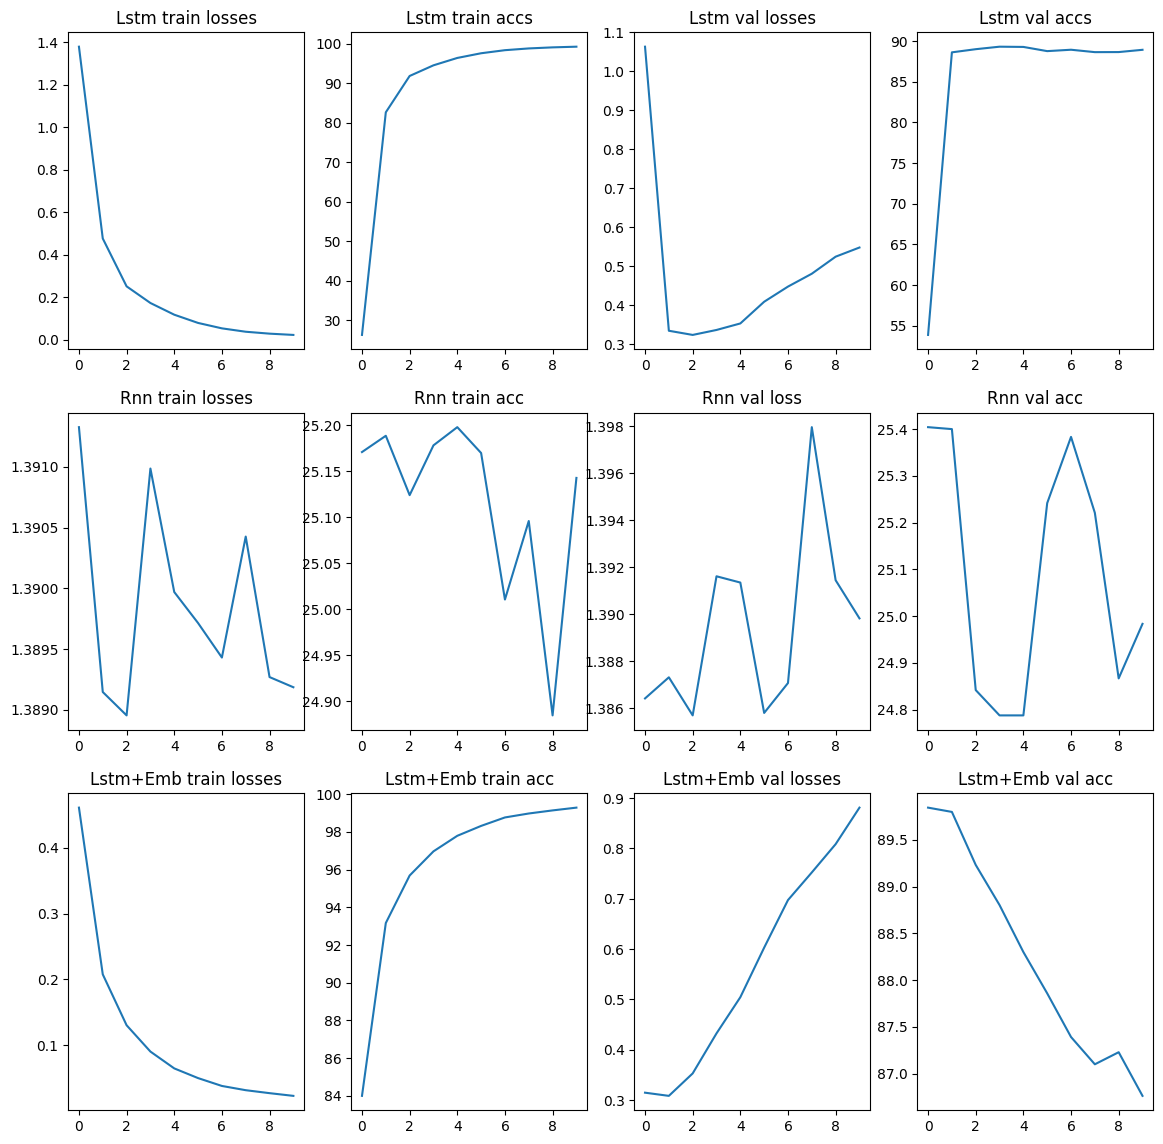

In [80]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Training accuracies & losses were saved for every model. Display here.

fig, axs = plt.subplots(3, 4)

fig.set_figheight(14)
fig.set_figwidth(14)


# Lstm stats
axs[0, 0].plot(lstm_train_losses)
axs[0, 0].set_title('Lstm train losses')
axs[0, 1].plot(lstm_train_accs)
axs[0, 1].set_title('Lstm train accs')
axs[0, 2].plot(lstm_val_losses)
axs[0, 2].set_title('Lstm val losses')
axs[0, 3].plot(lstm_val_accs)
axs[0, 3].set_title('Lstm val accs')

# Rnn stats
axs[1, 0].plot(rnn_train_loss)
axs[1, 0].set_title('Rnn train losses')
axs[1, 1].plot(rnn_train_acc)
axs[1, 1].set_title('Rnn train acc')
axs[1, 2].plot(rnn_val_loss)
axs[1, 2].set_title('Rnn val loss')
axs[1, 3].plot(rnn_val_acc)
axs[1, 3].set_title('Rnn val acc')

# lstm + embedding bag layer.
axs[2, 0].plot(e_train_loss)
axs[2, 0].set_title('Lstm+Emb train losses')
axs[2, 1].plot(e_train_acc)
axs[2, 1].set_title('Lstm+Emb train acc')
axs[2, 2].plot(e_val_loss)
axs[2, 2].set_title('Lstm+Emb val losses')
axs[2, 3].plot(e_val_acc)
axs[2, 3].set_title('Lstm+Emb val acc')


plt.show()

# 18) Predictions/Evaluation

In [132]:
''' The lstm and rnn models don't require offsets like the lstm + embedding bag layer model does, so the predictions will 
    be different just like the training functions were. First tokenize testing text '''

display_num = 3
test_tokens = [tk(sent) for sent in test_df['preprocessed_sentences']]
print(f'test_tokens length: {len(test_tokens)}\n{display_num} test tokens:\n{test_tokens[:display_num]}\n\n')

test_tokens length: 7600
3 test tokens:
[['unions', 'representing', 'workers', 'at', 'turner', 'newall', 'say', 'they', 'are', 'disappointed', 'after', 'talks', 'with', 'stricken', 'parent', 'firm', 'federal', 'mogul'], ['spacecom', 'toronto', 'canada', 'a', 'secondteam', 'of', 'rocketeers', 'competing', 'for', 'the', '3610', 'million', 'ansari', 'x', 'prize', 'a', 'contest', 'forprivately', 'funded', 'suborbital', 'space', 'flight', 'has', 'officially', 'announced', 'the', 'firstlaunch', 'date', 'for', 'its', 'manned', 'rocket'], ['ap', 'a', 'company', 'founded', 'by', 'a', 'chemistry', 'researcher', 'at', 'the', 'university', 'of', 'louisville', 'won', 'a', 'grant', 'to', 'develop', 'a', 'method', 'of', 'producing', 'better', 'peptides', 'which', 'are', 'short', 'chains', 'of', 'amino', 'acids', 'the', 'building', 'blocks', 'of', 'proteins']]




In [133]:
# Convert to nums
# x_train_sequences = [vocab(tk(text)) for text in x_train]
test_sequences = [vocab(text) for text in test_tokens]
print(f'test_sequences length: {len(test_sequences)}\n{display_num} test sequences:\n{test_sequences[:display_num]}\n\n')

test_sequences length: 7600
3 test sequences:
[[1609, 3264, 384, 14, 6898, 43941, 215, 52, 32, 4482, 28, 257, 11, 13312, 2065, 321, 140, 9663], [2969, 590, 698, 2, 0, 4, 26163, 3351, 8, 1, 9543, 68, 5475, 2325, 1252, 2, 3387, 0, 6937, 11357, 225, 936, 19, 2064, 96, 1, 0, 2036, 8, 13, 3930, 1208], [34, 2, 45, 6170, 17, 2, 10852, 4899, 14, 1, 464, 4, 4487, 194, 2, 3832, 3, 1264, 2, 6862, 4, 3809, 597, 34796, 74, 32, 934, 6228, 4, 31370, 20418, 1, 1007, 5007, 4, 11623]]




In [134]:
# Padding.cs = current sequence
test_padded = [pad_num_sentences(cs, max_padding_len) for cs in test_sequences]
print(f'{display_num} test padded sequences:\n{test_padded[:display_num]}')

3 test padded sequences:
[tensor([ 1609,  3264,   384,    14,  6898, 43941,   215,    52,    32,  4482,
           28,   257,    11, 13312,  2065,   321,   140,  9663,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor([ 2969,   590,   698,     2,     0,     4, 26163,  3351,     8,     1,
         9543,    68,  5475,  2325,  1252,     2,  3387,     0,  6937, 11357,
          225,   936,    19,  2064,    96,     1,     0,  2036,     8,    13,
         3930,  1208,     0,     0, 

In [135]:
# Convert labels as done before.
test_np = np.array(test_df['Class Index'].tolist())
print(f'Numpy labels:\n{test_np}\n\n')

print(f'Total different values: {set(test_np)}\n\n')

max_of_test_np = max(set(test_np))
print(f'Max value: {max_of_test_np}\n\n')

test_np[test_np == max_of_test_np] = 0
print(f'NEW total different values: {set(test_np)}')

Numpy labels:
[3 4 4 ... 2 3 3]


Total different values: {1, 2, 3, 4}


Max value: 4


NEW total different values: {0, 1, 2, 3}


In [136]:
# Convert to dataset then dataloader
test_data = TextDataset(test_padded, test_np)

test_data[0]

(tensor([ 1609,  3264,   384,    14,  6898, 43941,   215,    52,    32,  4482,
            28,   257,    11, 13312,  2065,   321,   140,  9663,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 3)

In [138]:
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [141]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function for predictions for lstm and rnn models
def evaluate_model(model, test_dl, print_details=False):
    model.eval()
    
    with torch.no_grad():
        # Accuracy calculate with total predictions and correct ones.
        total_test_samples = 0
        correct_predictions = 0
        
        # Save predictions and ground truths
        predictions = []
        ground_truths = []
        
        show = 3
        
        for data, labels in test_dl:
            # Copy of inputs with .clone
            data = data.to(device)
            labels = labels.to(device)
            
            # Predict
            outputs = model(data)     
            # With a 2d matrix, torch.max with dim=1 will go row by row to get highest value indices.
            _, indices = torch.max(outputs, dim=1)

            
            ''' Calculate acc correctly needs total every iteration. Ex: 7/10 first batch, next batch 
                will be 10, so total viewed would be 20. '''
            total_test_samples = total_test_samples + len(data)
            if print_details is True:
                print(f'Total samples in this batch: {total_test_samples}\n')
            
            ''' Both indices/predictions and labels are numerical tensors. == Will return a boolean tensor to see
                which indices/predictions MATCH. Ex: Indices can start with 0,0,2 and labels could be 0,0,2 meaning
                model got them all right. If they match? The boolean tensor will have true, if not, false, like
                below:
                
                "tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
                         True,  True,  True,  True, False, False,  True,  True,  True,  True,
                         True,  True,  True,  True, False, False,  True,  True,  True, False,
                         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
                         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
                         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
                         True,  True,  True,  True], device='cuda:0')"
                         
                Then .sum gets total that were correct because boolean values are just 1s and 0s. .item() just gets
                the actual number. '''
            correct_predictions = correct_predictions + (indices == labels).sum().item()
            if print_details is True:
                print(f'Correct predictions in this batch: {correct_predictions}\n')
                # Be sure to set boolean to false to stop printing.
                print_details = False
            
            # Keep adding predictions and ground truths to lists.
            predictions.extend(indices.tolist())
            ground_truths.extend(labels.tolist())
            
        accuracy = correct_predictions / total_test_samples
        
        print(f"Accuracy: {accuracy:.4f}")
            
evaluate_model(lstm_model, test_loader, True)
evaluate_model(rnn_model, test_loader, True)

Total samples in this batch: 64

Correct predictions in this batch: 55

Accuracy: 0.8855
Total samples in this batch: 64

Correct predictions in this batch: 15

Accuracy: 0.2513


# 19) Optuna

In [101]:
import optuna

''' Need smaller portion of dataset because hp tuning can take a while. The data loaders (train & 
    val) are built from the TextDataset Dataset class. Each TextDataset given x train/val padded
    sentences and y train/val labels just like the following code:
    "train_data = TextDataset(x_train_padded, y_train_np)
     val_data = TextDataset(x_val_padded, y_val_np)" '''


# portion = 10
# portion = 50
# portion = 200
# portion = 500
portion = 750

_sample_x_train_padded = x_train_padded[:portion]
_sample_y_train_np = y_train_np[:portion]

_sample_x_val_padded = x_val_padded[:portion]
_sample_y_val_np = y_val_np[:portion]

print(f'Portion size: {portion}\n')

show = 2
print(f'{portion} in portion. Will show {show} of x_train_padded:\n{_sample_x_train_padded[:show]}\n')
print(f'{portion} in portion. Will show {show} of y_train_np:\n{_sample_y_train_np[:show]}\n')
print(f'{portion} in portion. Will show {show} of x_val_padded:\n{_sample_x_val_padded[:show]}\n')
print(f'{portion} in portion. Will show {show} of y_val_np:\n{_sample_y_val_np[:show]}\n')

Portion size: 750

750 in portion. Will show 2 of x_train_padded:
[tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
           13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
         1910,  8672,     6,   159,  1090,  5997,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor([  458,   365,  5504,   772,    37,  3539,     4,     2, 19982,  1235,
            1,  4329,  1891,     4,     2,  1712,  1502,  2622,  2250,     1,
        11822,     4,     2,   458, 61493,    14,  1712,    53,    62,   

In [102]:
''' Make Datasets of _sample_x_train_padded, _sample_y_train_np, _sample_x_val_padded and _sample_y_val_np 
    before DataLoaders can be made. '''

_train_data = TextDataset(_sample_x_train_padded, _sample_y_train_np)
_val_data = TextDataset(_sample_x_val_padded, _sample_y_val_np)

_train_data[0], len(_train_data)

((tensor([15598,    19,  1272, 34089,  7223,   260,    11,     1,  3042,     9,
             13,   263,  2728,  2982,  1389,   407,     8,   242,   715,   597,
           1910,  8672,     6,   159,  1090,  5997,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
  0),
 750)

In [103]:
''' Now DataLoaders. Ex: Sample data length 10 and batch size 2? Each iteration over train loader 
    gives 5 batches of 2 because 10 (total amount in data) / 2 (batch size) = 5. If length 10 and 
    batch_size 3? Iteration gives 4 batches. 3 batches of 3, for a total of 9. Last one has 1. '''

# _batch_size = 10
# _batch_size = 50
# _batch_size = 150
_batch_size = 250

_train_loader = DataLoader(_train_data + _val_data, batch_size=_batch_size, shuffle=True)
_val_loader = DataLoader(_train_data + _val_data, batch_size=_batch_size, shuffle=True)

# for i, x in enumerate(_train_loader):
#     print(f'Batch {i} length: {len(x)}\nValue:\n{x}\n\n')

len(_train_loader)

6

# 20) Testing Optuna

In [104]:
''' Need define_model function. Trial arg "process of evaluating an objective function. This 
    object is passed to an objective function and provides interfaces to get parameter suggestion"
    Quote from: https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html 
    define_model isn't object function, but trial can still be used within it to suggest that
    Optuna experiment with values. '''

class RnnModelOptuna(nn.Module):
    
    ''' Old constructor: "def __init__(self, vocab_size, embedding_dim, num_classes, hidden_size, num_layers=1, display=True):"
    
        [1] Things I won't be changing: 
            1) vocab_size

            2) num_classes - Video guy https://www.youtube.com/watch?v=P6NwZVl8ttc&t=1194s didn't change certain things,
                so I believe I'm in fair play if I don't either. He didn't change:
                    1) in_features
                    2) relu layer
                    3) output of 2nd linear layer
                    4) logsoftmax 
                    At ALL
                    
                
                    IMPORTANT, the next 2 won't be changed, for now at least, because I ASSUME they're not that vital
                    compared to lr, optimizer, etc. This quote "The importance module provides functionality for 
                    evaluating hyperparameter importances based on completed trials in a given study." From this link:
                    https://optuna.readthedocs.io/en/stable/reference/importance.html makes it clear I have to do some
                    testing first. COMPLETED trials even. Staying away from changing below for now.

            3) hidden_size - Default "hidden_size = 128" from earlier cell but this isn't the most important if I remember
                an article that I read before. Therefore no need to waste time. To add to that, the following is a quote:

                "The difficulty of optimization increases roughly exponentially with regard to the number of parameters. 
                That is, the number of necessary trials increases exponentially when you increase the number of parameters, 
                so it is recommended to not add unimportant parameters." 
                From: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html

                    So this supports me in not bothering to change less important values.

            4) embedding_dim - Same reason as above.
        
        
        [2] Things I will be changing:
            1) num_layers  '''
    def __init__(self, vocab_size, embedding_dim, num_classes, hidden_size, num_layers):
        super().__init__()
        # Unchanged variables.
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.num_classes = num_classes
        self.hidden_size = hidden_size

        # Changable variables.
        self.num_layers = num_layers
    
        # Remaining layers.
        self.rnn = nn.RNN(input_size=self.embedding_dim,
                          hidden_size=self.hidden_size,
                          num_layers=self.num_layers,
                          batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size, self.num_classes)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        x = self.embedding(x)
        x, hs = self.rnn(x, h0)
        x = x[:, -1, :]
        x = self.fc(x)
        return x
    

def define_model(trial):
    num_layers = trial.suggest_int("num_layers", 1,3)
    rmo = RnnModelOptuna(vocab_size=vocab_size,
                         embedding_dim=embedding_dim,
                         num_classes=num_classes,
                         hidden_size=hidden_size,
                         num_layers=num_layers)
    
    return rmo

In [105]:
''' Normally Optuna is used with a regular Object FUNCTION. See https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html 
    for examples. But it's possible to use classes and I find them useful because I can save variables as I do later in the project.
    The below code takes in a simple min and max for one class object (that'll be SAVED by Optuna and used with every trial) and
    called repeatedly. '''

class ObjectiveClassTest:
    def __init__(self, min_x, max_x):
        # Hold this implementation specific arguments as the fields of the class.
        self.min_x = min_x
        self.max_x = max_x

    def __call__(self, trial):
        print(f'__call__ func is called! min: {self.min_x}. max: {self.max_x}')
        # Calculate an objective value by using the extra arguments.
        x = trial.suggest_float("x", self.min_x, self.max_x)
        return x * 2


# Execute an optimization by using an `Objective` instance.
study = optuna.create_study()
study.optimize(ObjectiveClassTest(1, 5), n_trials=3)

[I 2024-03-26 23:24:03,321] A new study created in memory with name: no-name-0a8b573f-9f37-47d9-a89f-9c8e807604f9
[I 2024-03-26 23:24:03,323] Trial 0 finished with value: 4.835011715527719 and parameters: {'x': 2.4175058577638593}. Best is trial 0 with value: 4.835011715527719.
[I 2024-03-26 23:24:03,325] Trial 1 finished with value: 8.456484052422196 and parameters: {'x': 4.228242026211098}. Best is trial 0 with value: 4.835011715527719.
[I 2024-03-26 23:24:03,326] Trial 2 finished with value: 9.991363524765955 and parameters: {'x': 4.9956817623829775}. Best is trial 0 with value: 4.835011715527719.


__call__ func is called! min: 1. max: 5
__call__ func is called! min: 1. max: 5
__call__ func is called! min: 1. max: 5


In [106]:
import torch.optim as optim
import torch.nn as nn
from pathlib import Path

''' Googled: optuna UnboundLocalError("local variable referenced before assignment"). and got:
    https://github.com/optuna/optuna/issues/2272 '''

class Objective(object):
    def __init__(self, model_and_optimizer_path):
        # Checking if better models have increased validation accuracy for debugging purposes
        self.val_accuracy = 0

        # Base path for model/optimizer. Then specific paths.
        self.base_path = model_and_optimizer_path
        self.model_path = self.base_path + '/mysavedmodel.pth'
        self.optimizer_path = self.base_path + '/mysavedoptimizer.pth'
        
        

    # If a class object is created, then ex: "classobj()" is done, below function is called.
    def __call__(self, trial):
        # Make model. PLACE ON DEVICE
        model = define_model(trial).to(device)

        optimizer_name = trial.suggest_categorical("optimizer", ["Adadelta", "Adam", "Adagrad", "ASGD", "RMSprop", "Rprop", "SGD"])
        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
        
        # Works: CrossEntropyLoss, NLLLoss
        loss_name = trial.suggest_categorical("loss_function", ["CrossEntropyLoss", "NLLLoss", "MultiMarginLoss"])
        _criterion = getattr(nn, loss_name)()
        
        first_loop_epochs = 1
        for i in range(first_loop_epochs):        
            # Train the model now. Higher for more hp tuning. "epochs = 10" declared in previous cell
            r_train_loss, r_train_acc, r_val_loss, r_val_acc = train(model=model, 
                                                                     epochs=50, 
                                                                     train_loader=_train_loader, 
                                                                     optimizer=optimizer, 
                                                                     criterion=_criterion,
                                                                     val_loader=_val_loader,
                                                                     device=device,
                                                                     display=False)
        
            cur_val_accuracy = np.sum(r_val_acc) / len(r_val_acc)
        
            if cur_val_accuracy > self.val_accuracy:
                print(f'{cur_val_accuracy} > {self.val_accuracy}, updating best val accuracy now,\n')
                self.val_accuracy = cur_val_accuracy
                
                # Model saving, check if model exists.
                if os.path.exists(self.model_path):
                    # Model here, but new one is better. Delete this one.
                    os.remove(self.model_path)
                    os.remove(self.optimizer_path)
                    torch.save(model, self.model_path) 
                    torch.save(optimizer, self.optimizer_path)
                    print(f'***1) Old model deleted, replaced with new model at {self.model_path}')
                    print(f'***2) Old optimizer deleted, replaced with new optimizer at {self.optimizer_path}')
                else:
                    # Path doesn't exist. Create it to save the data. 
                    Path(self.base_path).mkdir(parents=True, exist_ok=False)
                    torch.save(model, self.model_path) 
                    torch.save(optimizer, self.optimizer_path)
                    print(f'***1) First model saved at dir {self.model_path}!')
                    print(f'***2) First optimizer saved at dir {self.optimizer_path}')
                    
                
                
            # Update Optuna on how well this first_loop_epoch went
            trial.report(cur_val_accuracy, i)
        
            # Pruning basically stops continuing with this model training if its not improving.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        return self.val_accuracy

In [107]:
study = optuna.create_study(direction='maximize')

_trials = 400

_base_path = os.getcwd() + '/testing'

study.optimize(Objective(_base_path), n_trials=_trials, timeout=600)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics:\n")
print(f'Number of finished trials: {len(study.trials)}')
print(f'Number of pruned trials: {len(pruned_trials)}')
print(f'Number of complete trials: {len(completed_trials)}\n\n')

best_trial = study.best_trial
print(f'Best trial: {best_trial}\n\n')

print('Params:')
for key, value in best_trial.params.items():
    print('{} - {}'.format(key, value))

[I 2024-03-26 23:24:03,359] A new study created in memory with name: no-name-c618c7b3-bde9-4e47-a77a-666f1ec86491


25.58 > 0, updating best val accuracy now,



[I 2024-03-26 23:24:07,828] Trial 0 finished with value: 25.58 and parameters: {'num_layers': 2, 'optimizer': 'ASGD', 'lr': 0.0019905308207949154, 'loss_function': 'MultiMarginLoss'}. Best is trial 0 with value: 25.58.


***1) First model saved at dir /kaggle/working/testing/mysavedmodel.pth!
***2) First optimizer saved at dir /kaggle/working/testing/mysavedoptimizer.pth
25.84 > 25.58, updating best val accuracy now,



[I 2024-03-26 23:24:13,946] Trial 1 finished with value: 25.84 and parameters: {'num_layers': 1, 'optimizer': 'Rprop', 'lr': 0.002474893427684963, 'loss_function': 'MultiMarginLoss'}. Best is trial 1 with value: 25.84.


***1) Old model deleted, replaced with new model at /kaggle/working/testing/mysavedmodel.pth
***2) Old optimizer deleted, replaced with new optimizer at /kaggle/working/testing/mysavedoptimizer.pth


[I 2024-03-26 23:24:18,981] Trial 2 finished with value: 25.84 and parameters: {'num_layers': 1, 'optimizer': 'Adadelta', 'lr': 0.004203031843739835, 'loss_function': 'NLLLoss'}. Best is trial 1 with value: 25.84.
[I 2024-03-26 23:24:22,129] Trial 3 finished with value: 25.84 and parameters: {'num_layers': 1, 'optimizer': 'ASGD', 'lr': 0.008567072112398552, 'loss_function': 'MultiMarginLoss'}. Best is trial 1 with value: 25.84.
[I 2024-03-26 23:24:27,905] Trial 4 finished with value: 25.84 and parameters: {'num_layers': 2, 'optimizer': 'Adadelta', 'lr': 6.227313067046738e-05, 'loss_function': 'CrossEntropyLoss'}. Best is trial 1 with value: 25.84.
[I 2024-03-26 23:24:30,686] Trial 5 pruned. 
[I 2024-03-26 23:24:34,372] Trial 6 finished with value: 25.84 and parameters: {'num_layers': 1, 'optimizer': 'Adagrad', 'lr': 0.03505832983504587, 'loss_function': 'MultiMarginLoss'}. Best is trial 1 with value: 25.84.
[I 2024-03-26 23:24:40,585] Trial 7 finished with value: 25.84 and parameters: 

26.17733333333333 > 25.84, updating best val accuracy now,



[I 2024-03-26 23:27:35,986] Trial 45 finished with value: 26.17733333333333 and parameters: {'num_layers': 3, 'optimizer': 'RMSprop', 'lr': 0.006801349376601515, 'loss_function': 'MultiMarginLoss'}. Best is trial 45 with value: 26.17733333333333.


***1) Old model deleted, replaced with new model at /kaggle/working/testing/mysavedmodel.pth
***2) Old optimizer deleted, replaced with new optimizer at /kaggle/working/testing/mysavedoptimizer.pth


[I 2024-03-26 23:27:41,124] Trial 46 pruned. 
[I 2024-03-26 23:27:46,254] Trial 47 pruned. 
[I 2024-03-26 23:27:50,667] Trial 48 pruned. 
[I 2024-03-26 23:27:57,136] Trial 49 pruned. 
[I 2024-03-26 23:28:03,333] Trial 50 finished with value: 26.17733333333333 and parameters: {'num_layers': 2, 'optimizer': 'Rprop', 'lr': 0.003331949401792242, 'loss_function': 'MultiMarginLoss'}. Best is trial 45 with value: 26.17733333333333.
[I 2024-03-26 23:28:09,588] Trial 51 pruned. 
[I 2024-03-26 23:28:15,788] Trial 52 finished with value: 26.17733333333333 and parameters: {'num_layers': 2, 'optimizer': 'Rprop', 'lr': 0.0017095118801785394, 'loss_function': 'MultiMarginLoss'}. Best is trial 45 with value: 26.17733333333333.
[I 2024-03-26 23:28:22,702] Trial 53 pruned. 
[I 2024-03-26 23:28:28,885] Trial 54 finished with value: 26.17733333333333 and parameters: {'num_layers': 2, 'optimizer': 'Rprop', 'lr': 0.0011284748224846498, 'loss_function': 'MultiMarginLoss'}. Best is trial 45 with value: 26.177

62.52799999999999 > 26.17733333333333, updating best val accuracy now,



[I 2024-03-26 23:31:40,633] Trial 86 finished with value: 62.52799999999999 and parameters: {'num_layers': 2, 'optimizer': 'Rprop', 'lr': 0.008120397555291703, 'loss_function': 'MultiMarginLoss'}. Best is trial 86 with value: 62.52799999999999.


***1) Old model deleted, replaced with new model at /kaggle/working/testing/mysavedmodel.pth
***2) Old optimizer deleted, replaced with new optimizer at /kaggle/working/testing/mysavedoptimizer.pth


[I 2024-03-26 23:31:45,045] Trial 87 pruned. 
[I 2024-03-26 23:31:48,623] Trial 88 pruned. 
[I 2024-03-26 23:31:52,544] Trial 89 pruned. 
[I 2024-03-26 23:31:58,744] Trial 90 pruned. 
[I 2024-03-26 23:32:04,937] Trial 91 pruned. 
[I 2024-03-26 23:32:11,150] Trial 92 pruned. 
[I 2024-03-26 23:32:18,173] Trial 93 finished with value: 62.52799999999999 and parameters: {'num_layers': 3, 'optimizer': 'Rprop', 'lr': 0.0018766629734991893, 'loss_function': 'MultiMarginLoss'}. Best is trial 86 with value: 62.52799999999999.
[I 2024-03-26 23:32:24,373] Trial 94 pruned. 
[I 2024-03-26 23:32:29,926] Trial 95 pruned. 
[I 2024-03-26 23:32:36,850] Trial 96 pruned. 
[I 2024-03-26 23:32:43,775] Trial 97 finished with value: 62.52799999999999 and parameters: {'num_layers': 3, 'optimizer': 'Rprop', 'lr': 0.001841592868112465, 'loss_function': 'MultiMarginLoss'}. Best is trial 86 with value: 62.52799999999999.
[I 2024-03-26 23:32:50,745] Trial 98 pruned. 
[I 2024-03-26 23:32:55,915] Trial 99 pruned. 
[I 

Study statistics:

Number of finished trials: 111
Number of pruned trials: 67
Number of complete trials: 44


Best trial: FrozenTrial(number=86, state=TrialState.COMPLETE, values=[62.52799999999999], datetime_start=datetime.datetime(2024, 3, 26, 23, 31, 33, 790167), datetime_complete=datetime.datetime(2024, 3, 26, 23, 31, 40, 633137), params={'num_layers': 2, 'optimizer': 'Rprop', 'lr': 0.008120397555291703, 'loss_function': 'MultiMarginLoss'}, user_attrs={}, system_attrs={}, intermediate_values={0: 62.52799999999999}, distributions={'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'optimizer': CategoricalDistribution(choices=('Adadelta', 'Adam', 'Adagrad', 'ASGD', 'RMSprop', 'Rprop', 'SGD')), 'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'loss_function': CategoricalDistribution(choices=('CrossEntropyLoss', 'NLLLoss', 'MultiMarginLoss'))}, trial_id=86, value=None)


Params:
num_layers - 2
optimizer - Rprop
lr - 0.008120397555291703
loss_function - M

In [109]:
_model_path = os.getcwd() + '/testing' + '/mysavedmodel.pth' 
_optimizer_path = os.getcwd() + '/testing' + '/mysavedoptimizer.pth'

# Load both model and optimizer
_loaded_m = torch.load(_model_path)
_loaded_o = torch.load(_optimizer_path)

_loaded_m, _loaded_o

(RnnModelOptuna(
   (embedding): Embedding(93149, 200)
   (rnn): RNN(200, 128, num_layers=2, batch_first=True)
   (fc): Linear(in_features=128, out_features=4, bias=True)
 ),
 Rprop (
 Parameter Group 0
     differentiable: False
     etas: (0.5, 1.2)
     foreach: None
     lr: 0.008120397555291703
     maximize: False
     step_sizes: (1e-06, 50)
 ))

In [110]:
''' Test to get same val acc. 

    Regarding loss function, it wasn't saved. Could also use the params in the
    study objects best trial like: "for key, value in study.best_trial.params.items()" items will be a 
    dictionary and printing them will be like "print('{} - {}'.format(key, value))". 1 will be the loss
    function name, and it can be loaded like I loaded them in the Objective function which was:
    
    "loss_name = trial.suggest_categorical("loss_function", ["CrossEntropyLoss", "NLLLoss", "MultiMarginLoss"])
     _criterion = getattr(nn, loss_name)()""

    Except it'd be more simple like giving the optim library and then the loss name with no suggest_categorical. '''

_loss = nn.MultiMarginLoss()

_val_loss, _val_acc = validate(model=_loaded_m,
                               val_loader=_val_loader,
                               criterion=_loss,
                               log_interval=500,
                               device=device,
                               display=True,
                               return_data_as_lists=True)

_val_acc

[83.2, 84.2, 84.53333333333333, 84.2, 84.24000000000001, 83.73333333333333]

In [112]:
np.sum(_val_acc) / len(_val_acc)

84.01777777777778

# 21) Big difference on Optuna RNN an improvement on previous RNN

In [131]:
''' Keep in mind the amount of data and epochs used to train this new rnn model. Due to how long the process of 
    hyper parameter tuning can be, I set a certain portion of data, a considerably SMALLER portion, to be used
    for the new rnns val loader. 1500 to be exact (as of 3/26/2024). Batch size is 250. 
    The ORIGINAL rnn val loader had 24000, batch size of 64. 
    
    DESPITE the smaller data given to the new rnn, I'd say it done fairly well. Had I had unlimited gpu with 
    kaggle, I'd crank up some more hyperparameters and of course get better results. But speed and time is
    a crucial factor with any project.

'''
print(f'NEW Data loader len given to NEW rnn {len(_val_loader.dataset)}. Batch size: {_val_loader.batch_size}. Batches: {len(_val_loader)}\n\n')
print(f'Old Data loader len given to old rnn {len(val_loader.dataset)}. Batch size: {val_loader.batch_size}. Batches: {len(val_loader)}')

NEW Data loader len given to NEW rnn 1500. Batch size: 250. Batches: 6


Old Data loader len given to old rnn 24000. Batch size: 64. Batches: 375


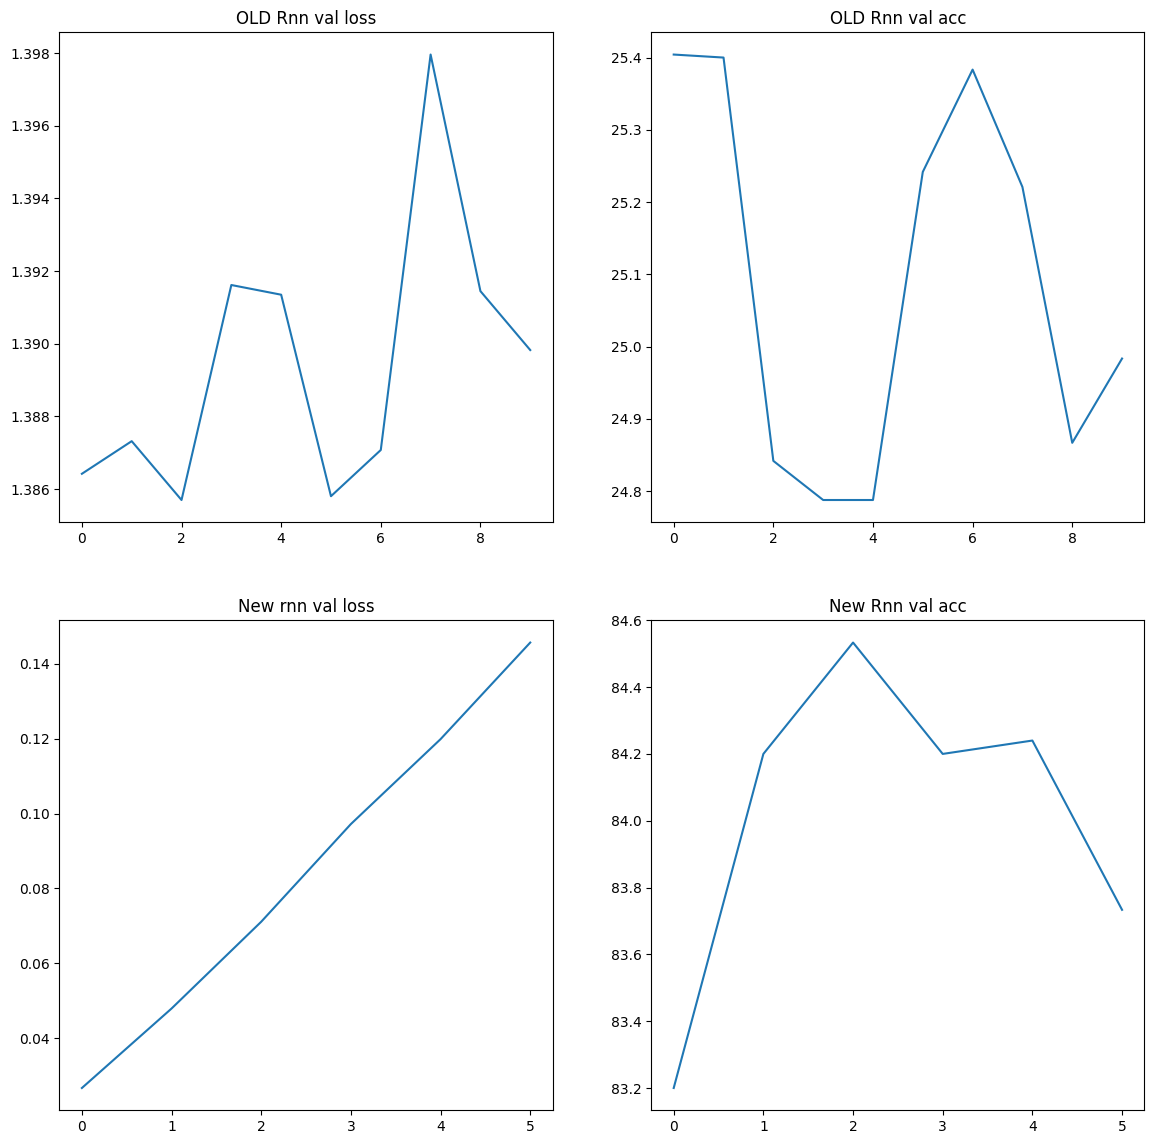

In [114]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Training accuracies & losses were saved for every model. Display here.

fig, axs = plt.subplots(2, 2)

fig.set_figheight(14)
fig.set_figwidth(14)

# Old rnn stats
axs[0, 0].plot(rnn_val_loss)
axs[0, 0].set_title('OLD Rnn val loss')
axs[0, 1].plot(rnn_val_acc)
axs[0, 1].set_title('OLD Rnn val acc')

# NEW Rnn stats
axs[1, 0].plot(_val_loss)
axs[1, 0].set_title('New rnn val loss')
axs[1, 1].plot(_val_acc)
axs[1, 1].set_title('New Rnn val acc')


plt.show()